# Cross-Module Student Key Overlap Analysis

## 1. Import Libraries & Load Master Data

In [1]:
# Import libraries and load master dataset
import pandas as pd
import duckdb

file = "C:/Users/Admin/Documents/GitHub/sams/data/raw/master_df_stack_v2.pq"
master_df_stack_v2 = pd.read_parquet(file)
master_df_stack_v2.head()

,academic_year,dob,exam_board,module,passing_year,roll_no,roll_no_decrypted,secured_marks,student_key,student_name,total_marks
0,2017,01-Jan-2002,"board of secondary education, odisha, cuttack-...",ITI,2017,"""PoLOLFcCUYZ/iR42DWBy2A==""",105ae0003,<NA>,"AKASH GARNAYAK_105ae0003_01-Jan-2002_2017_bse,...",AKASH GARNAYAK,<NA>
1,2017,20-Apr-2000,"board of secondary education, odisha, cuttack-...",ITI,2015,"""Gb1fbGJ4hl2z+FvcTECm4A==""",NA,<NA>,"AMARENDRA SAHOO_NA_20-Apr-2000_2015_bse, odisha",AMARENDRA SAHOO,<NA>
2,2017,07-Oct-2001,"board of secondary education, odisha, cuttack-...",ITI,2017,"""LjH/WJQkl9UJzVJCu+CaSQ==""",170af0002,<NA>,"ANIL MOHARANA_170af0002_07-Oct-2001_2017_bse, ...",ANIL MOHARANA,<NA>
3,2017,05-Nov-1999,"board of secondary education, odisha, cuttack-...",ITI,2015,"""3czUb8VotFM3QA1R8yE/Jw==""",NA,<NA>,"ASHISA ROUT_NA_05-Nov-1999_2015_bse, odisha",ASHISA ROUT,<NA>
4,2017,20-Apr-1999,"board of secondary education, odisha, cuttack-...",ITI,2014,"""BpFNV6ZmrmdtbEcHJS6eGg==""",NA,<NA>,"BABULI MAJHI_NA_20-Apr-1999_2014_bse, odisha",BABULI MAJHI,<NA>


In [5]:
# Check columns in master dataset
master_df_stack_v2.columns

Index(['academic_year', 'dob', 'exam_board', 'module', 'passing_year',
       'roll_no', 'roll_no_decrypted', 'secured_marks', 'student_key',
       'student_name', 'total_marks'],
      dtype='object')

In [29]:
master_df_stack_v2['module'].value_counts()

module
HSS        21136161
DEG        14640073
BSE         1617255
ITI          559575
Diploma      558879
Name: count, dtype: int64

# Understanding Educational Progression Pipeline

We need to track students' educational journey over time:
- Example: HSS Class 12 in 2020 → Degree enrollment in 2023
- This is NOT about same year overlaps, but progression across years

In [37]:
import duckdb

duckdb.sql("""
SELECT 
    module,
    COUNT(DISTINCT student_key) AS unique_student_keys
FROM master_df_stack_v2
GROUP BY module
ORDER BY unique_student_keys DESC;
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬─────────────────────┐
│ module  │ unique_student_keys │
│ varchar │        int64        │
├─────────┼─────────────────────┤
│ HSS     │             2945260 │
│ DEG     │             1632921 │
│ BSE     │             1616755 │
│ Diploma │              526880 │
│ ITI     │              526355 │
│ NULL    │                   1 │
└─────────┴─────────────────────┘

In [56]:
# Detailed table: Students appearing in BOTH HSS and DEG (across all years)

hss_deg_students_query = """
WITH hss_deg_overlap AS (
    -- Find students who appear in BOTH HSS and DEG
    SELECT DISTINCT h.student_key
    FROM (SELECT DISTINCT student_key FROM master_stack WHERE module = 'HSS') h
    INNER JOIN (SELECT DISTINCT student_key FROM master_stack WHERE module = 'DEG') d
        ON h.student_key = d.student_key
)
SELECT 
    m.student_name,
    m.student_key,
    STRING_AGG(DISTINCT m.module, ', ' ORDER BY m.module) as modules_present
FROM master_stack m
WHERE m.student_key IN (SELECT student_key FROM hss_deg_overlap)
    AND m.student_key IS NOT NULL
    AND m.student_key != ''
GROUP BY m.student_name, m.student_key
ORDER BY m.student_name
"""

hss_deg_students = con.execute(hss_deg_students_query).df()

print("\n" + "="*120)
print("DETAILED TABLE: Students appearing in BOTH HSS and DEG")
print("="*120)
print(f"Total students: {len(hss_deg_students):,}")
print("="*120)
hss_deg_students

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


DETAILED TABLE: Students appearing in BOTH HSS and DEG
Total students: 31


,student_name,student_key,modules_present
0,0xlVAHecGUbdwnO2VMXx8NKupqVd+KlPzEWqAJ+y0hQ=,0xlVAHecGUbdwnO2VMXx8NKupqVd+KlPzEWqAJ+y0hQ=_2...,"DEG, HSS"
1,Apc7W7OL7zYbhd9ziUEIcTq4ZkoEOBhafdSulyFMQDM=,Apc7W7OL7zYbhd9ziUEIcTq4ZkoEOBhafdSulyFMQDM=_1...,"DEG, HSS"
2,BPXP/Ox4aqwfwmq6BlQJZuIFBHHiOQwwxSWC65LAUDI=,BPXP/Ox4aqwfwmq6BlQJZuIFBHHiOQwwxSWC65LAUDI=_6...,"DEG, HSS"
3,D+11o4uUbFcTBnlHt7FFEF8RN5HQ3uaWhAPb5c8ERhU=,D+11o4uUbFcTBnlHt7FFEF8RN5HQ3uaWhAPb5c8ERhU=_1...,"DEG, HSS"
4,DJHUPoyBb+gJmqoj/TtSlp3XfvT3NP56ziw4WlDsnas=,DJHUPoyBb+gJmqoj/TtSlp3XfvT3NP56ziw4WlDsnas=_9...,"DEG, HSS"
5,Fz/NbnCnXuHN2TBjMaJvBoZ1PLeL2U2JDKAN4ia1qC4=,Fz/NbnCnXuHN2TBjMaJvBoZ1PLeL2U2JDKAN4ia1qC4=_2...,"DEG, HSS"
6,IRtajzHTiPy/6w/q+UjcqH0BWVV/+p9vCqoQYpWKxv4=,IRtajzHTiPy/6w/q+UjcqH0BWVV/+p9vCqoQYpWKxv4=_m...,"DEG, HSS"
7,It/Kg8jXABJZlsJgmRT+t3qybszgfb+vhl8TBYeWmWk=,It/Kg8jXABJZlsJgmRT+t3qybszgfb+vhl8TBYeWmWk=_1...,"DEG, HSS"
8,JrR0VRe6feuTvWSHNw2IaZphcDg90WQNnrcdgF9ua78=,JrR0VRe6feuTvWSHNw2IaZphcDg90WQNnrcdgF9ua78=_1...,"DEG, HSS"
9,O940tJ3mNcBaRw5qnSjWmo6UYAtLzE1dfkdI9k20YFc=,O940tJ3mNcBaRw5qnSjWmo6UYAtLzE1dfkdI9k20YFc=_1...,"DEG, HSS"


In [59]:
modules = ['ITI', 'Diploma', 'HSS', 'DEG', 'BSE']

# Generate total counts
total_selects = [f"COUNT(DISTINCT CASE WHEN module = '{m}' THEN student_key END) as total_{m}" 
                 for m in modules]

# Generate pair overlaps
pair_selects = []
for i, m1 in enumerate(modules):
    for m2 in modules[i+1:]:  # Only pairs, no duplicates
        pair_selects.append(f"""
    COUNT(DISTINCT student_key) FILTER (WHERE student_key IN 
        (SELECT student_key FROM student_modules WHERE module = '{m1}') AND student_key IN 
        (SELECT student_key FROM student_modules WHERE module = '{m2}')) as "{m1}+{m2}" """.strip())

# Build complete query
query = f"""
WITH student_modules AS (
    SELECT DISTINCT student_key, module
    FROM master_stack
    WHERE student_key IS NOT NULL AND student_key != ''
        AND module IN ({', '.join([f"'{m}'" for m in modules])})
)
SELECT 
    {', '.join(total_selects)},
    {', '.join(pair_selects)}
FROM student_modules
"""

result = con.execute(query).df()

# Display results
print("\n" + "="*100)
print("MODULE TOTALS & OVERLAPS (across all years)")
print("="*100)

print("\nTOTALS:")
for m in modules:
    print(f"  {m}: {result[f'total_{m}'].iloc[0]:,}")

print("\nOVERLAPS (students in BOTH):")
for i, m1 in enumerate(modules):
    for m2 in modules[i+1:]:
        print(f"  {m1}+{m2}: {result[f'{m1}+{m2}'].iloc[0]:,}")

print("="*100)
result

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


MODULE TOTALS & OVERLAPS (across all years)

TOTALS:
  ITI: 526,355
  Diploma: 526,880
  HSS: 2,945,260
  DEG: 1,632,921
  BSE: 1,616,755

OVERLAPS (students in BOTH):
  ITI+Diploma: 62,203
  ITI+HSS: 0
  ITI+DEG: 0
  ITI+BSE: 25,652
  Diploma+HSS: 0
  Diploma+DEG: 0
  Diploma+BSE: 19,277
  HSS+DEG: 31
  HSS+BSE: 0
  DEG+BSE: 0


,total_ITI,total_Diploma,total_HSS,total_DEG,total_BSE,ITI+Diploma,ITI+HSS,ITI+DEG,ITI+BSE,Diploma+HSS,Diploma+DEG,Diploma+BSE,HSS+DEG,HSS+BSE,DEG+BSE
0,526355,526880,2945260,1632921,1616755,62203,0,0,25652,0,0,19277,31,0,0


In [62]:
# DEEP DIAGNOSTIC: Why student_keys don't match between HSS and DEG
# Student key format: hash_rollnumber_dob_passingyear_examboard

# Extract components from student_key
component_analysis = """
WITH parsed_keys AS (
    SELECT 
        module,
        student_key,
        SPLIT_PART(student_key, '_', 1) as student_hash,
        SPLIT_PART(student_key, '_', 2) as roll_number,
        SPLIT_PART(student_key, '_', 3) as dob,
        SPLIT_PART(student_key, '_', 4) as passing_year,
        SPLIT_PART(student_key, '_', 5) as exam_board
    FROM master_stack
    WHERE module IN ('HSS', 'DEG')
        AND student_key IS NOT NULL
        AND student_key != ''
)
SELECT 
    'Issue 1: Same person, different roll numbers in HSS vs DEG' as issue_type,
    COUNT(DISTINCT student_hash) as affected_students
FROM parsed_keys
WHERE student_hash IN (
    SELECT student_hash 
    FROM parsed_keys 
    GROUP BY student_hash 
    HAVING COUNT(DISTINCT roll_number) > 1
)

UNION ALL

SELECT 
    'Issue 2: Same person, different passing years recorded',
    COUNT(DISTINCT student_hash)
FROM parsed_keys
WHERE student_hash IN (
    SELECT student_hash 
    FROM parsed_keys 
    GROUP BY student_hash 
    HAVING COUNT(DISTINCT passing_year) > 1
)

UNION ALL

SELECT 
    'Issue 3: Same person, different exam boards (HSS=CHSE, DEG=different)',
    COUNT(DISTINCT student_hash)
FROM parsed_keys
WHERE student_hash IN (
    SELECT student_hash 
    FROM parsed_keys 
    GROUP BY student_hash 
    HAVING COUNT(DISTINCT exam_board) > 1
)

UNION ALL

SELECT 
    'Students with same HASH appearing in both HSS and DEG',
    COUNT(DISTINCT h.student_hash)
FROM (SELECT DISTINCT student_hash FROM parsed_keys WHERE module = 'HSS') h
INNER JOIN (SELECT DISTINCT student_hash FROM parsed_keys WHERE module = 'DEG') d
    ON h.student_hash = d.student_hash
"""

component_result = con.execute(component_analysis).df()

print("\n" + "="*120)
print("ROOT CAUSE ANALYSIS: Why student_keys don't match between HSS and DEG")
print("="*120)
print("\nStudent key format: HASH_ROLLNUMBER_DOB_PASSINGYEAR_EXAMBOARD")
print("="*120)
print(component_result.to_string(index=False))

# Sample cases
sample_mismatch = """
SELECT 
    SPLIT_PART(student_key, '_', 1) as student_hash,
    module,
    SPLIT_PART(student_key, '_', 2) as roll_number,
    SPLIT_PART(student_key, '_', 4) as passing_year,
    SPLIT_PART(student_key, '_', 5) as exam_board,
    student_key
FROM master_stack
WHERE SPLIT_PART(student_key, '_', 1) IN (
    SELECT student_hash
    FROM (
        SELECT 
            SPLIT_PART(student_key, '_', 1) as student_hash,
            module
        FROM master_stack
        WHERE module IN ('HSS', 'DEG')
    ) sub
    GROUP BY student_hash
    HAVING COUNT(DISTINCT module) > 1
)
AND module IN ('HSS', 'DEG')
ORDER BY SPLIT_PART(student_key, '_', 1), module
LIMIT 10
"""

sample_result = con.execute(sample_mismatch).df()

print("\n" + "="*120)
print("SAMPLE: Same person (hash) with different components in HSS vs DEG")
print("="*120)
if len(sample_result) > 0:
    print(sample_result.to_string(index=False))
else:
    print("No samples found")

print("\n" + "="*120)
print("SOLUTION:")
print("="*120)
print("To properly integrate HSS and DEG, you should:")
print("1. Use the HASH part only (before first '_') as the true unique person identifier")
print("2. Roll numbers change between HSS and DEG (HSS has class 12 roll, DEG has enrollment number)")
print("3. Passing year in HSS (2019) ≠ DEG enrollment year (2020+)")
print("4. Exam board changes (HSS=CHSE/CBSE, DEG=university name)")
print("\nThis explains why student_key exact match gives low overlap!")
print("Use SPLIT_PART(student_key, '_', 1) to match the SAME PERSON across modules.")
print("="*120)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


ROOT CAUSE ANALYSIS: Why student_keys don't match between HSS and DEG

Student key format: HASH_ROLLNUMBER_DOB_PASSINGYEAR_EXAMBOARD
                                                           issue_type  affected_students
           Issue 1: Same person, different roll numbers in HSS vs DEG             579021
               Issue 2: Same person, different passing years recorded             566512
Issue 3: Same person, different exam boards (HSS=CHSE, DEG=different)             511551
                Students with same HASH appearing in both HSS and DEG             511176


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


SAMPLE: Same person (hash) with different components in HSS vs DEG
                                student_hash module roll_number passing_year   exam_board                                                                         student_key
+++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=    DEG    144pa089         2022 chse, odisha +++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=_144pa089_24-Jan-2005_2022_chse, odisha
+++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=    DEG    144pa089         2022 chse, odisha +++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=_144pa089_24-Jan-2005_2022_chse, odisha
+++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=    DEG    144pa089         2022 chse, odisha +++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=_144pa089_24-Jan-2005_2022_chse, odisha
+++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=    DEG    144pa089         2022 chse, odisha +++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=_144pa089_24-Jan-2005_2022_chse, odisha
+++FXEnKVCSQ1A5/HEnBgGWEsCpUuH8kihKU1A3rUkk=    DEG    144pa08

In [42]:
# CORRECT: Track students ACROSS DIFFERENT YEARS (Educational Progression)
# Example: Student in HSS in 2020 → Same student in DEG in 2023

across_years_query = """
WITH student_module_history AS (
    -- Get ALL modules each student has appeared in (across all years)
    SELECT 
        student_key,
        LIST(DISTINCT module ORDER BY module) as all_modules,
        MIN(academic_year) as first_year,
        MAX(academic_year) as last_year
    FROM master_stack
    WHERE student_key IS NOT NULL 
        AND student_key != ''
        AND module IN ('ITI', 'Diploma', 'HSS', 'DEG', 'BSE')
    GROUP BY student_key
)
SELECT 
    -- Count TOTAL students who appear in both modules (regardless of which year)
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'ITI') AND list_contains(all_modules, 'Diploma')) as "ITI→Diploma",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'ITI') AND list_contains(all_modules, 'HSS')) as "ITI→HSS",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'ITI') AND list_contains(all_modules, 'DEG')) as "ITI→DEG",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'Diploma') AND list_contains(all_modules, 'HSS')) as "Diploma→HSS",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'Diploma') AND list_contains(all_modules, 'DEG')) as "Diploma→DEG",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'HSS') AND list_contains(all_modules, 'DEG')) as "HSS→DEG",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'ITI') AND list_contains(all_modules, 'BSE')) as "ITI→BSE",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'Diploma') AND list_contains(all_modules, 'BSE')) as "Diploma→BSE",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'HSS') AND list_contains(all_modules, 'BSE')) as "HSS→BSE",
    COUNT(*) FILTER (WHERE list_contains(all_modules, 'DEG') AND list_contains(all_modules, 'BSE')) as "DEG→BSE",
    -- Students who appear in all four modules
    COUNT(*) FILTER (WHERE 
        list_contains(all_modules, 'ITI') AND 
        list_contains(all_modules, 'Diploma') AND 
        list_contains(all_modules, 'HSS') AND 
        list_contains(all_modules, 'DEG')
    ) as "All_Four_Modules"
FROM student_module_history
"""

across_years_total = con.execute(across_years_query).df()

print("\n" + "="*120)
print("STUDENT PROGRESSION ACROSS ALL YEARS")
print("Total count of students who appear in BOTH modules (across any years)")
print("Shows educational pathways: e.g., HSS in 2020 → DEG in 2023")
print("="*120)
across_years_total

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


STUDENT PROGRESSION ACROSS ALL YEARS
Total count of students who appear in BOTH modules (across any years)
Shows educational pathways: e.g., HSS in 2020 → DEG in 2023


,ITI→Diploma,ITI→HSS,ITI→DEG,Diploma→HSS,Diploma→DEG,HSS→DEG,ITI→BSE,Diploma→BSE,HSS→BSE,DEG→BSE,All_Four_Modules
0,62203,0,0,0,0,31,25652,19277,0,0,0


In [43]:
# DETAILED: Show progression from one module to another with year information
# Example: How many students went from HSS in 2020 to DEG in 2023?

detailed_progression_query = """
WITH student_module_years AS (
    SELECT DISTINCT 
        student_key,
        module,
        academic_year
    FROM master_stack
    WHERE student_key IS NOT NULL 
        AND student_key != ''
        AND module IN ('ITI', 'Diploma', 'HSS', 'DEG', 'BSE')
)
-- Example: HSS to DEG progression
SELECT 
    hss.academic_year as HSS_year,
    deg.academic_year as DEG_year,
    COUNT(DISTINCT hss.student_key) as student_count,
    (deg.academic_year - hss.academic_year) as year_gap
FROM student_module_years hss
INNER JOIN student_module_years deg
    ON hss.student_key = deg.student_key
    AND hss.module = 'HSS'
    AND deg.module = 'DEG'
    AND hss.academic_year < deg.academic_year  -- HSS came before DEG
GROUP BY hss.academic_year, deg.academic_year
ORDER BY hss.academic_year, deg.academic_year
"""

hss_to_deg_progression = con.execute(detailed_progression_query).df()

print("\n" + "="*120)
print("DETAILED PROGRESSION: HSS → DEG")
print("Shows which year students were in HSS and which year they appeared in DEG")
print("="*120)
hss_to_deg_progression

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


DETAILED PROGRESSION: HSS → DEG
Shows which year students were in HSS and which year they appeared in DEG


,HSS_year,DEG_year,student_count,year_gap
0,2018,2020,3,2
1,2018,2021,1,3
2,2019,2021,1,2
3,2019,2022,1,3
4,2020,2022,4,2
5,2020,2023,2,3
6,2021,2023,4,2
7,2022,2024,7,2



### What I Was Doing (WRONG Approach):
- Counting students who appeared in **multiple modules in the SAME academic year**
- Example: Student X in both HSS and DEG in 2020 → This is unusual/duplicate enrollment
- **Problem**: This doesn't show educational progression

### What I Should Be Doing (CORRECT Approach):
- Track students progressing through **different modules ACROSS different years**
- Example: Student X in HSS (class 12) in 2020 → Same student in DEG in 2023
- This shows the real educational pipeline - how students move from school to college/vocational training

- Can answer: "How many HSS graduates from 2020 enrolled in degree programs in subsequent years?"

## 2. Setup DuckDB Connection

In [6]:
# Load master dataset into DuckDB for efficient processing
con = duckdb.connect(database=':memory:')

# Register the parquet file directly
master_file = "C:/Users/Admin/Documents/GitHub/sams/data/raw/master_df_stack_v2.pq"

# Create table in DuckDB
con.execute(f"""
    CREATE TABLE master_stack AS 
    SELECT * FROM read_parquet('{master_file}')
""")

# Verify the data - check module counts
result = con.execute("SELECT module, COUNT(*) as count FROM master_stack GROUP BY module ORDER BY module").df()
print("Modules in master dataset:")
print(result)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Modules in master dataset:
    module     count
0      BSE   1617255
1      DEG  14640073
2  Diploma    558879
3      HSS  21136161
4      ITI    559575
5     None         2


## 3. Analysis 1: Module Overlap with BSE Students

## 4. Verification: Sample BSE Students in DEG/HSS

In [ ]:
## 5. Analysis 2: Module-to-Module Student Overlaps

In [14]:
# Pivot the data to create wide format table: academic_year | ITI+BSE | Diploma+BSE | HSS+BSE | DEG+BSE
pivot_df = overlap_df.pivot(
    index='academic_year',
    columns='module_pair',
    values='overlap_count'
).reset_index()

# Fill NaN values with 0
pivot_df = pivot_df.fillna(0).astype({col: int for col in pivot_df.columns if col != 'academic_year'})

# Reorder columns
desired_order = ['academic_year', 'ITI+BSE', 'Diploma+BSE', 'HSS+BSE', 'DEG+BSE']
existing_cols = [col for col in desired_order if col in pivot_df.columns]
other_cols = [col for col in pivot_df.columns if col not in existing_cols]
final_cols = existing_cols + other_cols

pivot_df = pivot_df[final_cols]

print("\n" + "="*80)
print("TABLE 1: Module Overlap with BSE Students by Academic Year")
print("="*80)
pivot_df


TABLE 1: Module Overlap with BSE Students by Academic Year


module_pair,academic_year,ITI+BSE,Diploma+BSE,HSS+BSE,DEG+BSE,BSE+BSE
0,2018,0,18,405436,7968,0
1,2019,0,13,382351,7378,0
2,2020,0,6,389526,9380,0
3,2021,0,5,441270,11192,0
4,2022,0,7,462471,13014,0
5,2023,24228,19264,472143,13649,541381
6,2024,2,8,479923,17044,562936
7,2025,0,0,0,0,512438


In [ ]:
master_df_stack_v2

In [23]:
# CORRECT: Find student_keys appearing in multiple modules
# Simplified approach using self-joins

integration_query = """
WITH module_students AS (
    SELECT DISTINCT 
        academic_year,
        module,
        student_key
    FROM master_stack
    WHERE student_key IS NOT NULL 
        AND student_key != ''
        AND module IN ('ITI', 'Diploma', 'HSS', 'DEG', 'BSE')
)
SELECT 
    academic_year,
    COUNT(DISTINCT CASE WHEN 'Diploma' IN (module1, module2) AND 'ITI' IN (module1, module2) THEN student_key END) as iti_diploma,
    COUNT(DISTINCT CASE WHEN 'HSS' IN (module1, module2) AND 'ITI' IN (module1, module2) THEN student_key END) as iti_hss,
    COUNT(DISTINCT CASE WHEN 'DEG' IN (module1, module2) AND 'ITI' IN (module1, module2) THEN student_key END) as iti_deg,
    COUNT(DISTINCT CASE WHEN 'DEG' IN (module1, module2) AND 'Diploma' IN (module1, module2) THEN student_key END) as diploma_deg,
    COUNT(DISTINCT CASE WHEN 'Diploma' IN (module1, module2) AND 'HSS' IN (module1, module2) THEN student_key END) as diploma_hss,
    COUNT(DISTINCT CASE WHEN 'DEG' IN (module1, module2) AND 'HSS' IN (module1, module2) THEN student_key END) as hss_deg,
    COUNT(DISTINCT CASE WHEN 'BSE' IN (module1, module2) AND 'ITI' IN (module1, module2) THEN student_key END) as iti_bse,
    COUNT(DISTINCT CASE WHEN 'BSE' IN (module1, module2) AND 'Diploma' IN (module1, module2) THEN student_key END) as diploma_bse,
    COUNT(DISTINCT CASE WHEN 'BSE' IN (module1, module2) AND 'HSS' IN (module1, module2) THEN student_key END) as hss_bse,
    COUNT(DISTINCT CASE WHEN 'BSE' IN (module1, module2) AND 'DEG' IN (module1, module2) THEN student_key END) as deg_bse
FROM (
    SELECT 
        m1.academic_year,
        m1.student_key,
        m1.module as module1,
        m2.module as module2
    FROM module_students m1
    INNER JOIN module_students m2
        ON m1.academic_year = m2.academic_year
        AND m1.student_key = m2.student_key
        AND m1.module < m2.module
) pairs
GROUP BY academic_year
ORDER BY academic_year
"""

integration_table = con.execute(integration_query).df()

# Rename columns to match requested format
integration_table.columns = [
    'academic_year',
    'ITI+Diploma',
    'ITI+HSS', 
    'ITI+DEG',
    'Diploma+DEG',
    'Diploma+HSS',
    'HSS+DEG',
    'ITI+BSE',
    'Diploma+BSE',
    'HSS+BSE',
    'DEG+BSE'
]

print("\n" + "="*120)
print("STUDENT KEY INTEGRATION TABLE")
print("Shows count of student_keys appearing in BOTH modules")
print("="*120)
integration_table


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


STUDENT KEY INTEGRATION TABLE
Shows count of student_keys appearing in BOTH modules


,academic_year,ITI+Diploma,ITI+HSS,ITI+DEG,Diploma+DEG,Diploma+HSS,HSS+DEG,ITI+BSE,Diploma+BSE,HSS+BSE,DEG+BSE
0,2018,3672,0,0,0,0,0,0,0,0,0
1,2019,3305,0,0,0,0,0,0,0,0,0
2,2020,2903,0,0,0,0,2,0,0,0,0
3,2021,2725,0,0,0,0,3,0,0,0,0
4,2022,4522,0,0,0,0,0,0,0,0,0
5,2023,4681,0,0,0,0,0,24228,19253,0,0
6,2024,3323,0,0,0,0,3,2,0,0,0


In [ ]:
# Sample verification - show students with BSE exam board in DEG/HSS modules
verification_query = """
SELECT 
    academic_year,
    student_name,
    module,
    student_key,
    exam_board
FROM master_stack
WHERE student_key IS NOT NULL 
    AND student_key != ''
    AND UPPER(exam_board) LIKE '%BSE%'
    AND module IN ('DEG', 'HSS')
ORDER BY module, academic_year
LIMIT 100
"""

verification_df = con.execute(verification_query).df()
print(f"Sample of {len(verification_df)} students with BSE exam board in DEG/HSS:")
verification_df

## Import libarires

In [4]:
# Standard libraries
import os
import json
import sqlite3
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

from sams.config import datasets
from sams.utils import load_data

from IPython.display import display_html

import duckdb
import importlib
import sams.utils
importlib.reload(sams.utils)  
# from sams.utils import decrypt_roll

import re

2025-11-10 12:28:28.238 | INFO     | sams.config:<module>:15 - PROJ_ROOT path is: C:\Users\Admin\Documents\GitHub\sams
2025-11-10 12:28:28.327 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-11-10 12:28:28.327 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache
2025-11-10 12:28:28.327 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-11-10 12:28:28.327 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache


### Load different datasets

In [2]:
iti_enrollments = load_data(datasets['iti_enrollments'])
diploma_enrollments = load_data(datasets['diploma_enrollments'])
deg_enrollments = load_data(datasets["deg_enrollments"]) 
hss_enrollments = load_data(datasets["hss_enrollments"])
deg_applications = load_data(datasets["deg_applications"])
hss_appplications = load_data(datasets["hss_applications"])

2025-11-05 15:14:49.321 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\iti_enrollments.pq
2025-11-05 15:14:52.122 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\diploma_enrollments.pq
2025-11-05 15:14:55.169 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\deg_enrollments.pq
2025-11-05 15:15:41.822 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\hss_enrollments.pq
2025-11-05 15:17:12.178 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\deg_applications.pq
2025-11-05 15:17:52.624 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\hss_applications.pq


### Extract ITI and Diploma enrollment data from the DB

In [4]:
# # Extract student data using duckdb

# def process_students_exploded(db_path, module):
#     con = duckdb.connect()
#     con.execute(f"ATTACH DATABASE '{db_path}' AS sqlite_db (TYPE SQLITE)")

#     query = f"""
#     SELECT
#         s.id AS sams_id,
#         s.academic_year,
#         s.barcode,
#         s.aadhar_no,
#         s.student_name,
#         s.dob,
#         s.admission_status,
#         json_extract(j.value, '$.YearofPassing') AS passing_year,
#         json_extract(j.value, '$.RollNo') AS roll_no,
#         json_extract(j.value, '$.ExaminationType') AS examination_type,
#         json_extract(j.value, '$.HighestQualificationExamBoard') AS exam_board
#     FROM sqlite_db.students s,
#          json_each(CAST(s.mark_data AS JSON)) j
#     WHERE s.module = '{module}'
#     ORDER BY s.id, j.key::INT
#     """

#     df = con.execute(query).arrow().to_pandas()
#     con.close()
#     return df

In [ ]:
db_path = datasets["sams"]["path"]

# Fetch ITI + Diploma students
conn = sqlite3.connect(db_path)
query = """
SELECT
    academic_year,
    aadhar_no,
    student_name,
    dob,
    admission_status,
    mark_data,
    module
FROM students
WHERE module IN ('ITI', 'Diploma');
"""
students_df = pd.read_sql_query(query, conn)
conn.close()

# Keys to extract from mark_data
keep_keys = ["YearofPassing", "RollNo", "ExaminationType", "HighestQualificationExamBoard"]

# Parse JSON and extract 
def extract_mark_data(mark_data):
    if isinstance(mark_data, str):
        try:
            mark_data = json.loads(mark_data)
        except json.JSONDecodeError:
            return {k: None for k in keep_keys}
    if isinstance(mark_data, list) and len(mark_data) > 0:
        entry = mark_data[0]
        return {k: entry.get(k) for k in keep_keys}
    return {k: None for k in keep_keys}

# Apply extraction
mark_columns = students_df["mark_data"].apply(extract_mark_data)
mark_df = pd.json_normalize(mark_columns)

# Combine with student info
df = pd.concat(
    [students_df.drop(columns=["mark_data"]), mark_df.rename(
        columns={
            "YearofPassing": "passing_year",
            "RollNo": "roll_no",
            "ExaminationType": "examination_type",
            "HighestQualificationExamBoard": "exam_board"
        }
    )],
    axis=1
)

# Separate ITI and Diploma
iti_enrollments = df[df["module"] == "ITI"]
diploma_enrollments = df[df["module"] == "Diploma"]

In [5]:
diploma_enrollments["admission_status"].value_counts()

admission_status
Yes                                                                                                                    341226
No                                                                                                                     134512
TC Taken : Institute - Satya Sai School of Engg. Diploma, Balasore Branch - ELECTRICAL                                     81
TC Taken : Institute - Satya Sai School of Engg. Diploma, Balasore Branch - MECHANICAL                                     60
TC Taken : Institute - Satya Sai School of Engg. Diploma, Balasore Branch - CIVIL                                          44
                                                                                                                        ...  
TC Taken : Institute - Bhubaneswar Engineering College (BEC), Gangapada, Bhubaneswar Branch - MECHANICAL                    1
TC Taken : Institute - City Inst.Of Technical Education, Kuanr Munda, Rourkela Branch - CIVIL        

In [6]:
iti_enrollments.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'highest_qualification', 'admission_status', 'module',
       'passing_year', 'roll_no', 'examination_type', 'exam_board'],
      dtype='object')

In [7]:
# make the new table with the datasets iti_enrollments and diploma_enrollments 
# table should calculate the total number of applications, number of unique applicants, number of admitted students, 
# number of students that has admission status with TC Taken in itT example C Taken : Institute - Satya Sai School of Engg. Diploma, Balasore Branch - ELECTRICAL 
# and in the end stduent_not_admitted

### Load ITI and Diploma applications data from DB

In [8]:
iti_applications = pd.read_parquet("iti_applications.pq")

In [9]:
conn = sqlite3.connect(db_path)

query = """
SELECT
    barcode,
    aadhar_no,
    academic_year,
    year,
    option_data
FROM students
WHERE module = 'Diploma';
"""

students_df = pd.read_sql_query(query, conn)
conn.close()

# Function to parse JSON strings safely
def parse_option_data(val):
    """
    Safely parses a JSON string into a Python object.

    Parameters:
    ----------
    val : str, list, or any
        The value to be parsed. If it's a JSON string, it will be decoded.
        If it's already a list, it is returned unchanged.
        All other types return an empty list.

    Returns:
    -------
    list
        Parsed list from JSON string, or the original list, or an empty list if parsing fails.
    """
    if isinstance(val, str):
        try:
            return json.loads(val)
        except json.JSONDecodeError:
            return []
    elif isinstance(val, list):
        return val
    else:
        return []

students_df['option_data'] = students_df['option_data'].apply(parse_option_data)
df_exploded = students_df.explode('option_data').reset_index(drop=True)
option_details = pd.json_normalize(df_exploded['option_data'])
diploma_applications = pd.concat([df_exploded.drop(columns=['option_data']), option_details], axis=1)

In [10]:
diploma_applications.columns

Index(['barcode', 'aadhar_no', 'academic_year', 'year', 'Phase', 'Option_No',
       'Institute_Name', 'Trade', 'Status'],
      dtype='object')

In [ ]:
# Calculate total applications per year
applications_by_year = (
    diploma_applications
    .groupby('year')['barcode']
    .count()
    .reset_index(name='total_applications')
)

# Display the result
print(applications_by_year)

   year  total_applications
0  2018               64218
1  2019               57824
2  2020               56600
3  2021               59278
4  2022               78196
5  2023               79700
6  2024               81789


### Summary of admitted, tc taken and not admitted ITI and Diploma students

In [28]:
def summary_table_ordered(iti_df, diploma_df, iti_apps, diploma_apps):
    # Helper to summarize a dataset
    def summarize(df):
        df_unique = df.drop_duplicates(subset=['aadhar_no', 'academic_year'])
        unique_applicant = df_unique.groupby('academic_year')['aadhar_no'].nunique()
        admitted = df_unique[df_unique['admission_status'] == 'Yes'].groupby('academic_year')['aadhar_no'].nunique()
        tc_taken = df_unique[df_unique['admission_status'].str.startswith('TC Taken', na=False)].groupby('academic_year')['aadhar_no'].nunique()
        not_admitted = df_unique[df_unique['admission_status'] == 'No'].groupby('academic_year')['aadhar_no'].nunique()
        summary = pd.concat([unique_applicant, admitted, tc_taken, not_admitted], axis=1).fillna(0).astype(int)
        summary.columns = ['unique', 'admitted', 'tc_taken', 'not_admitted']
        summary.reset_index(inplace=True)
        return summary

    # Summarize ITI and Diploma
    iti_sum = summarize(iti_df)
    diploma_sum = summarize(diploma_df)

    # Rename columns
    iti_sum.columns = ['academic_year', 'iti_unique_applicant', 'iti_admitted', 'iti_tc_taken', 'iti_not_admitted']
    diploma_sum.columns = ['academic_year', 'diploma_unique_applicant', 'diploma_admitted', 'diploma_tc_taken', 'diploma_not_admitted']

    # Add total applications for ITI and Diploma
    iti_apps_sum = iti_apps.groupby('year').size().reset_index(name='iti_total_applications')
    diploma_apps_sum = diploma_apps.groupby('year').size().reset_index(name='diploma_total_applications')

    # Merge everything
    combined = pd.merge(iti_sum, iti_apps_sum, left_on='academic_year', right_on='year', how='left').drop(columns=['year'])
    combined = pd.merge(combined, diploma_sum, on='academic_year', how='outer')
    combined = pd.merge(combined, diploma_apps_sum, left_on='academic_year', right_on='year', how='left').drop(columns=['year'])

    # Reorder columns
    columns_order = [
        'academic_year', 'iti_total_applications', 'iti_unique_applicant', 'iti_admitted', 'iti_tc_taken', 'iti_not_admitted',
        'diploma_total_applications', 'diploma_unique_applicant', 'diploma_admitted', 'diploma_tc_taken', 'diploma_not_admitted'
    ]
    combined = combined[columns_order].fillna(0).astype(int)

    return combined

# Usage
wide_summary = summary_table_ordered(iti_enrollments, diploma_enrollments, iti_applications, diploma_applications)
wide_summary.to_excel("iti_diploma_admission_status.xlsx", index=False)
wide_summary

,academic_year,iti_total_applications,iti_unique_applicant,iti_admitted,iti_tc_taken,iti_not_admitted,diploma_total_applications,diploma_unique_applicant,diploma_admitted,diploma_tc_taken,diploma_not_admitted
0,2017,145612,27337,13756,785,12796,0,0,0,0,0
1,2018,215662,70613,50159,3437,17017,203293,52530,35495,5,17030
2,2019,261505,64148,47546,4532,12070,186285,44080,31005,41,13034
3,2020,208581,67412,43668,8232,15512,181710,56533,40139,166,16228
4,2021,300121,68000,45079,8937,13984,175738,59278,44761,202,14315
5,2022,303082,74104,39196,16530,18378,244165,78196,55429,525,22242
6,2023,388380,92085,52386,13568,26131,270782,79700,57476,837,21387
7,2024,396042,83958,58247,2541,23170,290287,81789,58538,89,23162


In [ ]:
# def process_students_exploded(db_path, module):
#     con = duckdb.connect()
#     con.execute(f"ATTACH DATABASE '{db_path}' AS sqlite_db (TYPE SQLITE)")

#     query = f"""
#     SELECT
#         s.id AS sams_id,
#         s.academic_year,
#         s.barcode,
#         s.aadhar_no,
#         s.student_name,
#         s.dob,
#         s.admission_status,
#         json_extract(j.value, '$.YearofPassing') AS passing_year,
#         json_extract(j.value, '$.RollNo') AS roll_no,
#         json_extract(j.value, '$.ExaminationType') AS examination_type,
#         json_extract(j.value, '$.HighestQualificationExamBoard') AS exam_board
#     FROM sqlite_db.students s,
#          json_each(CAST(s.mark_data AS JSON)) j
#     WHERE s.module = '{module}'
#     ORDER BY s.id, j.key::INT
#     """

#     df = con.execute(query).arrow().to_pandas()
#     con.close()
#     return df

In [63]:
# check missing aadhar in hss_enrollments for each year
hss_missing_aadhar = hss_enrollments[hss_enrollments['aadhar_no'].isna()]
hss_missing_summary = hss_missing_aadhar.groupby('academic_year').size().reset_index(name='missing_aadhar_count')
hss_missing_summary

,academic_year,missing_aadhar_count
0,2018,52459
1,2019,35350
2,2020,57268
3,2021,94732
4,2022,82734
5,2023,81593
6,2024,17866


In [ ]:
def hss_admission_summary(df):
    total = df.groupby('year')['aadhar_no'].nunique().reset_index(name='unique_students')
    admitted = df[df['admission_status'] == 'ADMITTED'].groupby('year')['aadhar_no'].nunique().reset_index(name='admitted')
    return total.merge(admitted, on='year', how='left').fillna(0)

# Generate and print the summary table
summary = hss_admission_summary(hss_appplications)
print(summary)

   year  unique_students  admitted
0  2018           367553   78454.0
1  2019           353041   36690.0
2  2020           345841   45192.0
3  2021           375280   60869.0
4  2022           407039   56227.0
5  2023           419055   83207.0
6  2024           473009  413014.0
7   219                1       0.0


In [10]:
def admission_summary(df, year_col='academic_year'):
    """
    Generate yearly admission summary ensuring each Aadhaar is counted once
    according to a priority order of final admission status.
    """

    # Define priority order 
    status_priority = {
        'ADMITTED': 4,
        'TC TAKEN': 3,
        'SELECTED BUT NOT ADMITTED': 2,
        'NOT SELECTED': 1
    }

    known_statuses = set(status_priority.keys())
    df['admission_status'] = df['admission_status'].apply(
        lambda x: x if x in known_statuses else 'UNKNOWN'
    )

    df['priority'] = df['admission_status'].map(status_priority).fillna(0)


    # Keep only the record with highest priority per Aadhaar per year
    df = df.sort_values(by=[year_col, 'aadhar_no', 'priority'], ascending=[True, True, False])
    df_unique = df.drop_duplicates(subset=['aadhar_no', year_col], keep='first')

    # Total = total number of application rows per academic year
    total = df.groupby(year_col).size()

    # calculate the admitted, tc_taken, selected_but_not_admitted, not_selected counts
    admitted = df_unique[df_unique['admission_status'] == 'ADMITTED'].groupby(year_col)['aadhar_no'].nunique()
    tc_taken = df_unique[df_unique['admission_status'] == 'TC TAKEN'].groupby(year_col)['aadhar_no'].nunique()
    selected_but_not_admitted = df_unique[df_unique['admission_status'] == 'SELECTED BUT NOT ADMITTED'].groupby(year_col)['aadhar_no'].nunique()
    not_selected = df_unique[df_unique['admission_status'] == 'NOT SELECTED'].groupby(year_col)['aadhar_no'].nunique()

    summary = pd.concat([
        total, admitted, tc_taken, selected_but_not_admitted, not_selected
    ], axis=1, keys=[
        'applications', 'admitted', 'tc_taken',
        'selected_but_not_admitted', 'not_selected'
    ]).fillna(0).astype(int).reset_index()

    # Handle unknowns
    known_statuses = set(status_priority.keys())
    if any(~df_unique['admission_status'].isin(known_statuses)):
        unknown = df_unique[~df_unique['admission_status'].isin(known_statuses)] \
                    .groupby(year_col)['aadhar_no'].nunique()
        summary = pd.merge(summary, unknown, on=year_col, how='left')
        summary.rename(columns={'aadhar_no': 'unknown'}, inplace=True)
        summary['unknown'] = summary['unknown'].fillna(0).astype(int)
    else:
        summary['unknown'] = 0

    return summary


In [30]:
# HSS summary
hss_summary = admission_summary(hss_appplications).rename(columns={
    'applications': 'hss_applications',
    'admitted': 'hss_admitted',
    'tc_taken': 'hss_tc_taken',
    'selected_but_not_admitted': 'hss_selected_not_admitted',
    'not_selected': 'hss_not_selected',
    'unknown': 'hss_unknown'
})

# DEG summary
deg_summary = admission_summary(deg_applications).rename(columns={
    'applications': 'deg_applications',
    'admitted': 'deg_admitted',
    'tc_taken': 'deg_tc_taken',
    'selected_but_not_admitted': 'deg_selected_not_admitted',
    'not_selected': 'deg_not_selected',
    'unknown': 'deg_unknown'
})

# Merge final table
hss_deg_admitted_students = (
    pd.merge(hss_summary, deg_summary, on='academic_year', how='outer')
    .fillna(0)
    .astype(int)
)
hss_deg_admitted_students

,academic_year,hss_applications,hss_admitted,hss_tc_taken,hss_selected_not_admitted,hss_not_selected,hss_unknown,deg_applications,deg_admitted,deg_tc_taken,deg_selected_not_admitted,deg_not_selected,deg_unknown
0,2018,2237157,78454,244527,26265,16479,28,1519247,43180,122767,24202,11899,1344
1,2019,2060026,36690,280596,23697,9919,2260,1669860,42983,122946,30762,2619,29
2,2020,2280404,45192,253509,38174,7018,60,1594363,40874,111525,23848,14725,40
3,2021,2591931,60869,255412,41947,15015,88,2176487,64356,129148,36689,19243,226
4,2022,2772098,56227,277851,41989,28689,74,3199753,95705,104596,29871,25753,10
5,2023,3110640,83207,274472,43601,15627,80,2233931,178947,9747,42225,5361,14
6,2024,6083906,413014,4643,42119,12945,88,2246432,198424,10476,41955,11193,37


In [20]:
# save to excel
hss_deg_admitted_students.to_excel("hss_deg_admission_status.xlsx", index=False)

In [21]:
def admission_summary(df, year_col='academic_year'):
    admitted_statuses = ['ADMITTED', 'TC TAKEN']
    total = df.groupby(year_col)['aadhar_no'].nunique()
    admitted = df[df['admission_status'].isin(admitted_statuses)].groupby(year_col)['aadhar_no'].nunique()
    return pd.concat([total, admitted], axis=1, keys=['unique_applicant','applied']).fillna(0).astype(int).reset_index()

hss_summary = admission_summary(hss_appplications).rename(columns={'unique_applicant':'hss_unique_applicant','applied':'hss_applied'})
deg_summary = admission_summary(deg_applications).rename(columns={'unique_applicant':'deg_unique_applicant','applied':'deg_applied'})

# Merge final table
final_summary = pd.merge(hss_summary, deg_summary, on='academic_year', how='outer').fillna(0)
final_summary

,academic_year,hss_unique_applicant,hss_applied,deg_unique_applicant,deg_applied
0,2018,367581,324624,204305,166688
1,2019,355308,319277,200210,166645
2,2020,345901,300457,191843,153078
3,2021,375368,318054,250724,194274
4,2022,407113,336010,256801,200897
5,2023,419135,359564,236544,188738
6,2024,473097,417677,262392,208951


In [11]:
def determine_admission_status(option_details_json):
    """
    Parses a JSON string of application options and determines if the student
    was admitted in any of them.

    Args:
        option_details_json: A string containing a list of options in JSON format.

    Returns:
        'Yes' if any option has "ADMITTED" status, otherwise 'No'.
    """
    # Handle cases where the data might be empty or not a valid string (like NaN)
    if not isinstance(option_details_json, str):
        return 'No'

    try:
        # Load the JSON string into a Python list of dictionaries
        options_list = json.loads(option_details_json)
        
        # loop through each option in the list where AdmissionStatus is 'ADMITTED' 
        # for option in options_list:
        #     if option.get("AdmissionStatus") in ["ADMITTED", "TC TAKEN"]:
        #         return 'Yes'
        
        for option in options_list:
            if option.get("AdmissionStatus") == "ADMITTED":
                return 'Yes' 
                
    except json.JSONDecodeError:
        return 'No'
    
    # If the loop completes without finding an 'ADMITTED' status, return 'No'
    return 'No'

In [12]:
def clean_and_derive_status(df, keep_cols, option_col):
    """
    Cleans enrollment data and derives a final 'admission_status' by applying
    the status determination logic to the specified options column.
    """
    print(f"Processing DataFrame for column: {option_col}")

    cleaned = df[keep_cols].copy()
    
    cleaned['admission_status'] = df[option_col].apply(determine_admission_status)

    status_counts = cleaned['admission_status'].value_counts()
    
    yes_count = status_counts.get('Yes', 0)
    no_count = status_counts.get('No', 0)

    print("Generated Admission Status Counts:")
    print(f"  - Yes: {yes_count}")
    print(f"  - No:  {no_count}")
    
    return cleaned

In [13]:
# Define the columns you want to keep for the DEG dataset
deg_keep_cols = [
    'academic_year', 'barcode', 'aadhar_no', 'dob', 'year_of_passing',
    'roll_no', 'examination_type', 'examination_board_of_the_highest_qualification'
]

# Define the columns you want to keep for the HSS dataset
hss_keep_cols = [
    'id', 'student_name','academic_year', 'barcode', 'aadhar_no', 'dob', 'year_of_passing',
    'roll_no', 'examination_type', 'examination_board_of_the_highest_qualification'
]


hss_enroll = clean_and_derive_status(
    df=hss_enrollments, 
    keep_cols=hss_keep_cols, 
    option_col='hss_option_details'
)

deg_enroll = clean_and_derive_status(
    df=deg_enrollments, 
    keep_cols=deg_keep_cols, 
    option_col='deg_option_details'  
)

Processing DataFrame for column: hss_option_details
Generated Admission Status Counts:
  - Yes: 859834
  - No:  2593567
Processing DataFrame for column: deg_option_details
Generated Admission Status Counts:
  - Yes: 700406
  - No:  1354085


In [14]:
# Final schema across all modules
FINAL_SCHEMA = ["sams_id", "academic_year", "barcode", "aadhar_no","student_name", "dob",
     "passing_year", "roll_no", "examination_type", "exam_board", "admission_status",]

# Shared rename rules for DEG/HSS
BASE_DEG_HSS = { "id": "sams_id", "year_of_passing": "passing_year", "examination_board_of_the_highest_qualification": "exam_board",}

# Module-specific rename maps
RENAME_MAPS = {
    m: BASE_DEG_HSS for m in ("deg", "hss")}    

def clean_sams_dataset(df: pd.DataFrame, module: str) -> pd.DataFrame:
    """
    Clean and standardize SAMS datasets to a common schema.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw dataframe for a given module.
    module : str
        Module name: "DEG", "HSS".
    
    Returns
    -------
    pd.DataFrame
        Cleaned dataframe with FINAL_SCHEMA applied.
    """
    module = module.lower()
    rename_map = RENAME_MAPS.get(module, {})

    # Apply renaming
    df = df.rename(columns=rename_map)

    # Keep only overlapping columns, then reindex to FINAL_SCHEMA
    df = df.loc[:, df.columns.intersection(FINAL_SCHEMA)]
    df = df.reindex(columns=FINAL_SCHEMA)

    return df

iti_df = iti_enrollments
diploma_df = diploma_enrollments
hss_df = clean_sams_dataset(hss_enroll, "hss")
deg_df = clean_sams_dataset(deg_enroll, "deg")

In [11]:
hss_enrollments.head()

,id,barcode,aadhar_no,academic_year,module,student_name,gender,dob,social_category,orphan,...,examination_board_of_the_highest_qualification,examination_type,year_of_passing,total_marks,secured_marks,percentage,compartmental_status,hss_option_details,hss_compartments,full_address
0,2703360,18J1152889, qkm;ú]h¸n ðÿyvâ[ïôw\rxû)tñöšgþ,2018,HSS,HR81C4EOg2/hE8JRTrn1S6w33F6HtoV5YRG56S79UEc=,Male,2003-03-16,SC,False,...,"BSE, Odisha",Annual,2018.0,600.0,428.0,71.330002,False,"[{""ReportedInstitute"": ""AIMS Higher Secondary ...",[],"AT- CHAURAMAHUL, Lephripara, Sundargarh, Odish..."
1,2703361,18J1152893,ga£!oˆ©ª’ïëˆÿvëfëu’jój5›‘f‹ðjôâ,2018,HSS,RroqbpgtJBXrjGAqGwJEPnBOoDGW7l6AXUWeOI1+mlY=,Female,2001-09-06,ST,False,...,"BSE, Odisha",Annual,2018.0,600.0,233.0,38.830002,False,"[{""ReportedInstitute"": ""Pateswar Higher Second...",[],"AT/PO-PADADAR, Anandapur, Keonjhar, Odisha 758018"
2,2703362,18J1152906,óà®xðjmìøk@ú=ªð tàä±1ž³w á­œü0,2018,HSS,UaqS4u+DJL0F9xeHIAqVp/b7sijboaNytvQ6rEzCq/Y=,Male,2002-11-05,GEN,False,...,"BSE, Odisha",Annual,2018.0,600.0,235.0,39.169998,False,"[{""ReportedInstitute"": ""Brahmanajharilo Higher...",[],"AT-BHIMPUR, Balianta, Khurda, Odisha 752101"
3,2703363,18J1152926,df^»+\t`uö4™”4t¥mágàz¡˜ts,2018,HSS,IDsi45Z1rGc46/6z5Me/lgf+tc9AaoV7u4zpG+XpOMY=,Female,2002-05-12,OBC,False,...,"BSE, Odisha",Annual,2018.0,600.0,282.0,47.000000,False,"[{""ReportedInstitute"": ""Bhadrak Higher Seconda...",[],"AT-CHARAMPA, Bhadrak, Bhadrak, Odisha 756101"
4,2703364,18J1152933,None,2018,HSS,IDrYpLGzUi0AbxBk/9KcIwOJSNAG8GZt73d/ew9Nw2Q=,Female,2002-06-25,GEN,False,...,"BSE, Odisha",Annual,2018.0,600.0,232.0,38.669998,False,"[{""ReportedInstitute"": ""Dr. B.R.A. Higher Seco...",[],"AT/PO- PODAGADA VIA- LAXMIPUR, Dasmantpur, Kor..."


In [ ]:
hss_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,passing_year,roll_no,examination_type,exam_board,admission_status
0,NaN,2018,18J0054157,,NaN,07-Jul-2002,2018,OQpGykhOnzUDRJkE5xDqhA==,Annual,"BSE, Odisha",No
1,NaN,2018,18J0054211,,NaN,05-Dec-2002,2018,GGqv3Kdo8HZyK68MvPXQXg==,Annual,"BSE, Odisha",Yes
2,NaN,2018,18J0054354,,NaN,25-Aug-2003,2018,cHtLfCL89qhpsPRWMhcMCg==,Annual,"BSE, Odisha",Yes
3,NaN,2018,18J0054431,,NaN,20-Apr-2003,2018,0Cx1ngpH/vvmun5PtcC9yA==,Annual,"BSE, Odisha",Yes
4,NaN,2018,18J0054684,,NaN,20-Mar-2001,2018,d7usWOp/eZSqwAjwzjD4UA==,Annual,"BSE, Odisha",Yes


In [ ]:
hss_df.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'passing_year', 'roll_no', 'examination_type', 'exam_board',
       'admission_status'],
      dtype='object')

In [15]:
# code for decryption
from base64 import b64decode
from Crypto.Cipher import AES

def decrypt_roll(enc_text: str,
                 key: bytes = b"y6idXfCVRG5t2dkeBnmHy9jLu6TEn5Du",
                 enforce_min_length: bool = False,
                 min_length: int = None) -> str:
    try:
        if not enc_text or not isinstance(enc_text, str):
            return "NA"

        raw = b64decode(enc_text)
        cipher = AES.new(key, AES.MODE_ECB)
        decrypted = cipher.decrypt(raw)

        pad_len = decrypted[-1]
        if pad_len < 1 or pad_len > 16:
            return "NA"
        decrypted = decrypted[:-pad_len]

        roll_no = decrypted.decode("utf-8").strip()
        return roll_no
    except Exception:
        return "NA"    

In [16]:
def process_roll_numbers_len_format(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:
    """
    Decrypt roll numbers and validate only by length rule:
    - BSE Odisha: length must be 9
    - CHSE Odisha: length must be 8
    - Other boards: keep decrypted roll as-is
    """

    # Decrypt roll numbers
    df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Identify Odisha boards 
    board_col = df['exam_board'].fillna("NA").str.upper()
    # Put the condition to pass these input values of board name        
    mask_bse = (board_col.str.contains(r'\bBOARD OF SECONDARY EDUCATION,\s*ODISHA\b', regex=True)  
                | (board_col.str.contains(r'\bBSE\b(?! MADHYAMA).*ODISHA\b', regex=True) & ~board_col.str.contains(r'\bICSE\b|\bCBSE\b', regex=True)))
    
    mask_chse = (board_col.str.contains(r'\bCOUNCIL OF HIGHER SECONDARY EDUCATION,\s*ODISHA\b', regex=True) 
                 | board_col.str.contains(r'\bCHSE\b.*ODISHA\b', regex=True))

    # Apply validation
    if mask_bse.any():
        rolls_bse = df.loc[mask_bse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
        valid_bse = rolls_bse.str.len() == 9
        df.loc[mask_bse & ~valid_bse, 'roll_no_decrypted'] = 'NA'

    if mask_chse.any():
        rolls_chse = df.loc[mask_chse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
        valid_chse = rolls_chse.str.len() == 8
        df.loc[mask_chse & ~valid_chse, 'roll_no_decrypted'] = 'NA'

    return df

In [17]:
iti_df = process_roll_numbers_len_format(iti_df)
diploma_df = process_roll_numbers_len_format(diploma_df)
hss_df = process_roll_numbers_len_format(hss_df)
deg_df = process_roll_numbers_len_format(deg_df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23684\232470676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23684\232470676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)


In [26]:
iti_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,admission_status,module,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted
0,1,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,AKASH GARNAYAK,01-Jan-2002,10TH,Yes,ITI,2017,PoLOLFcCUYZ/iR42DWBy2A==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",105AE0003
1,2,2017,17T0114510,6/Vau/OfdeJ6NAV7iD6bmnbzGEexPB8LP/JcN1eroCs=,AMARENDRA SAHOO,20-Apr-2000,10TH,Yes,ITI,2015,Gb1fbGJ4hl2z+FvcTECm4A==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",NA
2,3,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,ANIL MOHARANA,07-Oct-2001,10TH,Yes,ITI,2017,LjH/WJQkl9UJzVJCu+CaSQ==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",170AF0002
3,4,2017,17T0288737,yg4tiEAGopVFYnXgybQlTen34PqwEI08id2hvZS9spw=,ASHISA ROUT,05-Nov-1999,10 TH,Yes,ITI,2015,3czUb8VotFM3QA1R8yE/Jw==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",NA
4,5,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,BABULI MAJHI,20-Apr-1999,12 TH,Yes,ITI,2014,BpFNV6ZmrmdtbEcHJS6eGg==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",NA


In [21]:
def encode_part(s: pd.Series, *, na_label="NA", missing_label="MISSING", lower=False) -> pd.Series:
    """
    Encode parts of a student key by handling missing/NA values consistently.
    """
    is_nan = s.isna()
    t = s.astype(str).str.strip()
    t = t.str.strip('"').str.strip("'")   # remove quotes if present

    out = t.copy()

    # Replace explicit NA and missing values
    out = out.mask(t.eq("NA"), na_label)
    out = out.mask(t.eq("") | is_nan, missing_label)

    # Normalize casing if requested
    if lower:
        out = out.where(out.isin([na_label, missing_label]), out.str.lower().str.strip())

    return out


In [ ]:
def generate_student_key_df(df, module_name: str) -> pd.DataFrame:
    """
    Clean key columns in-place, then generate a student_key
    and print diagnostics about duplicates.
    """
    new_df = df.copy()

    # Columns used for the key
    key_vars = ["passing_year", "dob",
                "roll_no_decrypted", "exam_board", "examination_type"]

    # Normalize these columns 
    for col in key_vars:
        new_df[col] = encode_part(new_df[col], lower=True)

    # Construct student key explicitly
    new_df["student_key"] = (
        new_df["student_name"] + "_" +
        new_df["roll_no_decrypted"] + "_" +
        new_df["dob"] + "_" +
        new_df["passing_year"] + "_" +
        new_df["exam_board"] + "_" +
        new_df["examination_type"]
    )

    # Diagnostics
    total_records = len(new_df)
    unique_aadhar = new_df["aadhar_no"].nunique()
    unique_keys = new_df["student_key"].nunique()

    # Problematic duplicates = same key linked to multiple Aadhaar numbers
    dup_check = (
        new_df.groupby("student_key")["aadhar_no"]
        .nunique(dropna=True)
        .reset_index(name="unique_aadhar_count")
    )
    problematic_keys = dup_check[dup_check["unique_aadhar_count"] > 1]["student_key"]

    # Count of problematic duplicate keys
    duplicate_keys_count = len(problematic_keys)

    # Count of rows affected by those problematic keys
    # duplicate_rows_count = new_df[new_df["student_key"].isin(problematic_keys)].shape[0]

    print(f"\n[{module_name}]")
    print("Total student records:", total_records)
    # print("Unique Aadhaar numbers:", unique_aadhar)
    print("Unique student keys generated:", unique_keys)
    print("Duplicate student keys:", duplicate_keys_count)
    # print("Total rows having duplicate keys:", duplicate_rows_count)

    return new_df

In [25]:
# Generate student key datasets
iti_key_df = generate_student_key_df(iti_df, "ITI")
diploma_key_df = generate_student_key_df(diploma_df, "Diploma")
hss_key_df = generate_student_key_df(hss_df, "HSS")
deg_key_df = generate_student_key_df(deg_df, "DEG")


[ITI]
Total student records: 559575
Unique Aadhaar numbers: 518024
Unique student keys generated: 424654
Duplicate student keys: 12625

[Diploma]
Total student records: 477605
Unique Aadhaar numbers: 417756
Unique student keys generated: 367684
Duplicate student keys: 11515

[HSS]
Total student records: 3453401
Unique Aadhaar numbers: 2650769
Unique student keys generated: 2883957
Duplicate student keys: 17879

[DEG]
Total student records: 2054491
Unique Aadhaar numbers: 1506304
Unique student keys generated: 1628267
Duplicate student keys: 2829


In [27]:
iti_key_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,admission_status,module,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,student_key
0,1,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,AKASH GARNAYAK,01-jan-2002,10TH,Yes,ITI,2017,PoLOLFcCUYZ/iR42DWBy2A==,annual,"board of secondary education, odisha, cuttack-...",105ae0003,105ae0003_01-jan-2002_2017_board of secondary ...
1,2,2017,17T0114510,6/Vau/OfdeJ6NAV7iD6bmnbzGEexPB8LP/JcN1eroCs=,AMARENDRA SAHOO,20-apr-2000,10TH,Yes,ITI,2015,Gb1fbGJ4hl2z+FvcTECm4A==,annual,"board of secondary education, odisha, cuttack-...",NA,NA_20-apr-2000_2015_board of secondary educati...
2,3,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,ANIL MOHARANA,07-oct-2001,10TH,Yes,ITI,2017,LjH/WJQkl9UJzVJCu+CaSQ==,annual,"board of secondary education, odisha, cuttack-...",170af0002,170af0002_07-oct-2001_2017_board of secondary ...
3,4,2017,17T0288737,yg4tiEAGopVFYnXgybQlTen34PqwEI08id2hvZS9spw=,ASHISA ROUT,05-nov-1999,10 TH,Yes,ITI,2015,3czUb8VotFM3QA1R8yE/Jw==,annual,"board of secondary education, odisha, cuttack-...",NA,NA_05-nov-1999_2015_board of secondary educati...
4,5,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,BABULI MAJHI,20-apr-1999,12 TH,Yes,ITI,2014,BpFNV6ZmrmdtbEcHJS6eGg==,annual,"board of secondary education, odisha, cuttack-...",NA,NA_20-apr-1999_2014_board of secondary educati...


In [ ]:
# Yearly admitted summary for ITI, Diploma, HSS and DEG
def create_yearly_summary(df):
    """Generate yearly summary for ITI or Diploma datasets."""
    def _metrics(g):
        mapping = g[['aadhar_no', 'student_key']].drop_duplicates()
        unique_aadhar = mapping['aadhar_no'].value_counts() == 1
        unique_key = mapping['student_key'].value_counts() == 1

        one_to_one = mapping[
            mapping['aadhar_no'].isin(unique_aadhar[unique_aadhar].index) &
            mapping['student_key'].isin(unique_key[unique_key].index)
        ]

        return pd.Series({
            'aadhar': g['aadhar_no'].nunique(),
            '1by1_match': len(one_to_one),
            'admitted': g['admission_status'].astype(str).str.lower().eq('yes').sum(),
        })

    return (
        df.groupby('academic_year', group_keys=False)
        .apply(_metrics)
        .reset_index()
    )


# Yearly summary for HSS and Degree
def create_admissions_summary(df, prefix):
    """Summarize yearly applicants and admissions for HSS or Degree."""
    return (
        df.groupby('academic_year')
        .agg(
            **{
                f'{prefix}_applicant': ('aadhar_no', 'nunique'),
                f'{prefix}_admitted': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'yes').sum()
                ),
            }
        )
        .reset_index()
    )


# Generate and merge all yearly summaries
iti_summary = create_yearly_summary(iti_key_df)
diploma_summary = create_yearly_summary(diploma_key_df)
hss_summary = create_admissions_summary(hss_key_df, prefix='hss')
deg_summary = create_admissions_summary(deg_key_df, prefix='deg')

final_summary = (
    iti_summary.merge(
        diploma_summary, on='academic_year', how='outer', suffixes=('_iti', '_diploma')
    )
    .merge(hss_summary, on='academic_year', how='outer')
    .merge(deg_summary, on='academic_year', how='outer')
)

final_summary.rename(
    columns={
        'academic_year': 'year',
        'aadhar_iti': 'iti_aadhar',
        '1by1_match_iti': 'iti_1by1_match',
        'admitted_iti': 'iti_admitted',
        'aadhar_diploma': 'diploma_aadhar',
        '1by1_match_diploma': 'diploma_1by1_match',
        'admitted_diploma': 'diploma_admitted',
    },
    inplace=True,
)

final_summary = final_summary[
    [
        'year',
        'iti_aadhar', 'iti_1by1_match', 'iti_admitted',
        'diploma_aadhar', 'diploma_1by1_match', 'diploma_admitted',
        'hss_applicant', 'hss_admitted',
        'deg_applicant', 'deg_admitted',
    ]
]

final_summary

In [ ]:
#export final summary to excel
final_summary.to_excel("sams_unique_id_aggregates_oct_28th_master_doc.xlsx", index=False)

In [24]:
iti_key_df.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'highest_qualification', 'admission_status', 'module',
       'passing_year', 'roll_no', 'examination_type', 'exam_board',
       'roll_no_decrypted', 'student_key'],
      dtype='object')

In [1]:
# check in the all the dataset of key_df, unique key and unique count of the barcode for each year
# table can be like, academic_year, dataset, unique_student_key, unique_barcode_count
# datasets are iti_key_df, diploma_key_df, hss_key_df, deg_key_df


In [ ]:
datasets = {
    'iti': iti_key_df,
    'diploma': diploma_key_df,
    'hss': hss_key_df,
    'deg': deg_key_df
}
summary_list = []

# Process each dataframe to get unique counts per academic year
for name, df in datasets.items():
    summary = df.groupby('academic_year').agg(
        unique_student_key=('student_key', 'nunique'),
        unique_barcode_count=('barcode', 'nunique')
    ).reset_index()

    # Rename columns to be specific to each dataset
    summary.rename(columns={
        'unique_student_key': f'{name}_unique_student_key',
        'unique_barcode_count': f'{name}_unique_barcode_count'
    }, inplace=True)

    summary_list.append(summary)

# Merge all the summary dataframes into a single final table
if summary_list:
    final_summary_df = summary_list[0]
    # Iteratively merge with the rest of the summaries
    for summary_df in summary_list[1:]:
        final_summary_df = pd.merge(
            final_summary_df,
            summary_df,
            on='academic_year',
            how='outer'
        )

    final_summary_df.fillna(0, inplace=True)
final_summary_df

,academic_year,iti_unique_student_key,iti_unique_barcode_count,diploma_unique_student_key,diploma_unique_barcode_count,hss_unique_student_key,hss_unique_barcode_count,deg_unique_student_key,deg_unique_barcode_count
0,2017,18750,34654,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,45743,75211,39867.0,64218.0,391167.0,439527.0,246028.0,312823.0
2,2019,53559,64148,47233.0,57824.0,376748.0,411117.0,223895.0,254342.0
3,2020,61113,67415,48994.0,56600.0,387522.0,431636.0,220912.0,242661.0
4,2021,62080,68000,53641.0,59278.0,439951.0,498180.0,256837.0,264152.0
5,2022,68690,74104,71778.0,78196.0,476360.0,574238.0,268163.0,379911.0
6,2023,86833,92085,75462.0,79700.0,477982.0,560769.0,242097.0,289849.0
7,2024,81123,83958,78290.0,81789.0,484652.0,537932.0,268308.0,310753.0


In [33]:
# count unique barcodes in hss_enrollments for each year    
hss_unique_barcodes = hss_enrollments.groupby('academic_year')['barcode'].nunique().reset_index(name='unique_barcodes_count')
hss_unique_barcodes

,academic_year,unique_barcodes_count
0,2018,439527
1,2019,411117
2,2020,431636
3,2021,498180
4,2022,574238
5,2023,560769
6,2024,537932


In [34]:
hss_enrollments.head()

,id,barcode,aadhar_no,academic_year,module,student_name,gender,dob,social_category,orphan,...,examination_board_of_the_highest_qualification,examination_type,year_of_passing,total_marks,secured_marks,percentage,compartmental_status,hss_option_details,hss_compartments,full_address
0,2703360,18J1152889, qkm;ú]h¸n ðÿyvâ[ïôw\rxû)tñöšgþ,2018,HSS,HR81C4EOg2/hE8JRTrn1S6w33F6HtoV5YRG56S79UEc=,Male,2003-03-16,SC,False,...,"BSE, Odisha",Annual,2018.0,600.0,428.0,71.330002,False,"[{""ReportedInstitute"": ""AIMS Higher Secondary ...",[],"AT- CHAURAMAHUL, Lephripara, Sundargarh, Odish..."
1,2703361,18J1152893,ga£!oˆ©ª’ïëˆÿvëfëu’jój5›‘f‹ðjôâ,2018,HSS,RroqbpgtJBXrjGAqGwJEPnBOoDGW7l6AXUWeOI1+mlY=,Female,2001-09-06,ST,False,...,"BSE, Odisha",Annual,2018.0,600.0,233.0,38.830002,False,"[{""ReportedInstitute"": ""Pateswar Higher Second...",[],"AT/PO-PADADAR, Anandapur, Keonjhar, Odisha 758018"
2,2703362,18J1152906,óà®xðjmìøk@ú=ªð tàä±1ž³w á­œü0,2018,HSS,UaqS4u+DJL0F9xeHIAqVp/b7sijboaNytvQ6rEzCq/Y=,Male,2002-11-05,GEN,False,...,"BSE, Odisha",Annual,2018.0,600.0,235.0,39.169998,False,"[{""ReportedInstitute"": ""Brahmanajharilo Higher...",[],"AT-BHIMPUR, Balianta, Khurda, Odisha 752101"
3,2703363,18J1152926,df^»+\t`uö4™”4t¥mágàz¡˜ts,2018,HSS,IDsi45Z1rGc46/6z5Me/lgf+tc9AaoV7u4zpG+XpOMY=,Female,2002-05-12,OBC,False,...,"BSE, Odisha",Annual,2018.0,600.0,282.0,47.000000,False,"[{""ReportedInstitute"": ""Bhadrak Higher Seconda...",[],"AT-CHARAMPA, Bhadrak, Bhadrak, Odisha 756101"
4,2703364,18J1152933,None,2018,HSS,IDrYpLGzUi0AbxBk/9KcIwOJSNAG8GZt73d/ew9Nw2Q=,Female,2002-06-25,GEN,False,...,"BSE, Odisha",Annual,2018.0,600.0,232.0,38.669998,False,"[{""ReportedInstitute"": ""Dr. B.R.A. Higher Seco...",[],"AT/PO- PODAGADA VIA- LAXMIPUR, Dasmantpur, Kor..."


In [ ]:
def get_admission_status(df, json_col):
    all_records = []

    # iterate through each row
    for idx, row in df.iterrows():
        try:
            # parse the JSON string safely
            options = json.loads(row[json_col]) if isinstance(row[json_col], str) else []
            for opt in options:
                status = opt.get('AdmissionStatus', '').strip().upper()
                year = opt.get('Year', None)
                all_records.append({
                    'id': row.get('id', None),
                    'year': year,
                    'AdmissionStatus': status
                })
        except Exception as e:
            continue

    status_df = pd.DataFrame(all_records)
    return status_df

# extract admission data
hss_status = get_admission_status(hss_enrollments, 'hss_option_details')

# summarize counts by status and year
admission_status_summary = (
    hss_status[hss_status['AdmissionStatus'].isin(['ADMITTED', 'TC TAKEN'])]
    .groupby(['year', 'AdmissionStatus'])
    .agg(student_count=('id', 'nunique'))
    .reset_index()
)
admission_status_summary

In [41]:
# we have four datatsets with ending *_key_df, and i got one varibale in it which is student_key
# i want to find how many student_key are common in all the four datasets
# how can we look if iti studnt key is appeared i rest of three and same for all
# maybe pich each student key and aadhar from each dataset adn rename all the column with dataset name suffix
# and then check 


In [40]:
iti_key_df.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'highest_qualification', 'admission_status', 'module',
       'passing_year', 'roll_no', 'examination_type', 'exam_board',
       'roll_no_decrypted', 'student_key'],
      dtype='object')

In [ ]:
deg_applications.head()

In [15]:
key_vars = ["aadhar_no","student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board"]

def generate_summary(df, key_vars):
    summary = []
    for col in key_vars:
        col_data = df[col].replace(["NA", "na", ""], pd.NA)
        
        total = len(col_data)
        missing = col_data.isna().sum()
        
        # Count frequency of each non-missing value
        freq = col_data.value_counts(dropna=True)
        
        # Unique = appear exactly once
        unique_rows = freq[freq == 1].sum()
        # Duplicates = appear more than once
        duplicate_rows = freq[freq > 1].sum()
        
        summary.append({
            "variable": col,
            "total_rows": total,
            "unique_count": unique_rows,
            "missing_count": missing,
            "duplicate_count": duplicate_rows
        })
        
    return pd.DataFrame(summary)


iti_summary = generate_summary(iti_df, key_vars)
diploma_summary = generate_summary(diploma_df, key_vars)
deg_summary = generate_summary(deg_df, key_vars)
hss_summary = generate_summary(hss_df, key_vars)

tables = [
    iti_summary.style.set_caption("ITI Summary"),
    diploma_summary.style.set_caption("Diploma Summary"),
    hss_summary.style.set_caption("HSS Summary"),
    deg_summary.style.set_caption("DEG Summary")
]

# Stack vertically with spacing
html = "<br><br>".join([t._repr_html_() for t in tables])  # 2 blank lines between tables
display_html(html, raw=True)

,variable,total_rows,unique_count,missing_count,duplicate_count
0,aadhar_no,559575,483453,0,76122
1,student_name,559575,226307,0,333268
2,dob,559575,1714,0,557861
3,passing_year,559575,5,0,559570
4,roll_no_decrypted,559575,294427,140204,124944
5,examination_type,559575,0,0,559575
6,exam_board,559575,3,1644,557928
,variable,total_rows,unique_count,missing_count,duplicate_count
0,aadhar_no,477605,385521,0,92084
1,student_name,477605,210178,0,267427


In [147]:
with pd.ExcelWriter("variable_missing_summary.xlsx", engine="openpyxl") as writer:
    # Each module summary into one sheet (stacked below each other)
    iti_summary.to_excel(writer, sheet_name="Summaries", startrow=1, index=False)
    diploma_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+4, index=False)
    hss_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+7, index=False)
    deg_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, index=False)

    # Add labels at the top of each block
    worksheet = writer.sheets["Summaries"]
    worksheet.cell(row=1, column=1).value = "ITI Summary"
    worksheet.cell(row=len(iti_summary)+4, column=1).value = "Diploma Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+7, column=1).value = "HSS Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, column=1).value = "DEG Summary"


In [18]:
# If a function with the same name exists, remove it
try:
    duckdb.remove_function("decrypt_roll")
except Exception:
    pass  # Safe to ignore if not previously registered

# Wrapper for DuckDB
def decrypt_roll_duckdb(enc_text: str) -> str:
    return decrypt_roll(enc_text)  # passes only the encrypted text, rest use defaults

# Register wrapper in DuckDB
duckdb.create_function("decrypt_roll", decrypt_roll_duckdb, ["VARCHAR"], "VARCHAR")

In [19]:
dfs = {
    "iti": iti_df,
    "diploma": diploma_df,
    "hss": hss_df,
    "deg": deg_df,
}

new_dfs = {}

for name, df in dfs.items():
    # Register this DataFrame in DuckDB
    duckdb.register("df", df)

    # Query with the decrypt function to add new column
    new_dfs[name] = duckdb.query("""
        SELECT *, decrypt_roll(roll_no) AS roll_no_original_decrypt
        FROM df
    """).to_df()

    # Unregister to avoid conflicts in next loop
    duckdb.unregister("df")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [54]:
iti_dec_roll = new_dfs["iti"]
diploma_dec_roll = new_dfs["diploma"]
hss_dec_roll = new_dfs["hss"]
deg_dec_roll = new_dfs["deg"]

In [210]:
#count how many rows have NA instead of decrypted values
def summarize_counts(df, name):
    total = len(df)
    orig = df['roll_no_original_decrypt'].fillna("").str.strip() != ""
    invalid = ((df['roll_no_decrypted'] == "NA") & orig).sum()
    valid = ((df['roll_no_decrypted'] != "NA") & orig).sum()
    return {"module": name, "total_rows": total, "rows_with_NA": invalid, "valid_rows": valid}

results = [
    summarize_counts(iti_dec_roll, "ITI"),
    summarize_counts(diploma_dec_roll, "Diploma"),
    summarize_counts(hss_dec_roll, "HSS"),
    summarize_counts(deg_dec_roll, "Degree"),
]
pd.DataFrame(results)

,module,total_rows,rows_with_NA,valid_rows
0,ITI,559575,140204,419371
1,Diploma,558879,122259,436619
2,HSS,3453401,115723,3337674
3,Degree,2054491,6369,2048121


In [214]:
def roll_no_student_summary(df, module_name):
    # group students and collect their roll numbers 
    student_summary = (
        df.groupby('aadhar_no')['roll_no_decrypted']
        .agg(lambda x: set([r for r in x if r != "NA"]))
        .reset_index(name="roll_set")
    )

    total_students = len(student_summary)
    students_with_roll = (student_summary['roll_set'].str.len() > 0).sum()
    students_without_roll = (student_summary['roll_set'].str.len() == 0).sum()

    return {
        "module": module_name,
        "total_rows": len(df),                    
        "unique_aadhar": total_students,
        "students_count_with_unique_roll_numbers": students_with_roll,
        "students_count_with_missing_roll_numbers": students_without_roll
    }

In [215]:
iti_summary = roll_no_student_summary(iti_df, "ITI")
diploma_summary = roll_no_student_summary(diploma_df, "Diploma")
hss_summary = roll_no_student_summary(hss_df, "HSS")
deg_summary = roll_no_student_summary(deg_df, "DEG")
summary_df = pd.DataFrame([iti_summary, diploma_summary,hss_summary,  deg_summary])
summary_df

,module,total_rows,unique_aadhar,students_count_with_unique_roll_numbers,students_count_with_missing_roll_numbers
0,ITI,559575,518025,394331,123694
1,Diploma,558879,417756,351891,65865
2,HSS,3453401,2650769,2566049,84720
3,DEG,2054491,1506304,1502792,3512


In [21]:
def aadhar_diagnostics_all(db_path: str, table: str = "students") -> pd.DataFrame:
    """
    Run Aadhaar diagnostics for all modules from the students table in DuckDB,
    excluding PDIS and ordering ITI → Diploma → HSS → DEG.
    """
    con = duckdb.connect(database=':memory:')
    con.execute(f"ATTACH DATABASE '{db_path}' AS sams")

    query = f"""
    WITH cleaned AS (
        SELECT 
            module,
            aadhar_no,
            NULLIF(TRIM(CAST(aadhar_no AS VARCHAR)), '') AS aadhar_clean
        FROM sams.{table}
        WHERE module IN ('ITI', 'Diploma', 'HSS', 'DEG')  -- explicitly exclude PDIS
    )
    SELECT 
        module,
        COUNT(*) AS total_rows,
        COUNT(DISTINCT aadhar_clean) AS unique_aadhar,
        SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) AS missing_aadhar_rows,
        COUNT(*) - COUNT(DISTINCT aadhar_no) - SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) 
            AS duplicate_aadhar_rows
    FROM cleaned
    GROUP BY module
    ORDER BY CASE module
        WHEN 'ITI' THEN 1
        WHEN 'Diploma' THEN 2
        WHEN 'HSS' THEN 3
        WHEN 'DEG' THEN 4
    END;
    """

    result = con.execute(query).df()
    con.close()
    return result

db_path = datasets["sams"]["path"]
aadhar_diag = aadhar_diagnostics_all(db_path)
aadhar_diag

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,module,total_rows,unique_aadhar,missing_aadhar_rows,duplicate_aadhar_rows
0,ITI,559575,518025,0.0,41550.0
1,Diploma,477605,417756,0.0,59849.0
2,HSS,3453401,2650769,422002.0,380629.0
3,DEG,2054491,1506304,144701.0,403485.0


In [ ]:
# 2. Duplicate Aadhaar summary
missing_mask = hss_df['aadhar_no'].isna() | (hss_df['aadhar_no'].astype(str).str.strip() == "")
non_missing = hss_df.loc[~missing_mask, 'aadhar_no']
freq = non_missing.value_counts()

duplicates_df = freq[freq > 1].reset_index()
duplicates_df.columns = ['aadhar_no', 'count']
print("\n=== Duplicate Aadhaar Summary ===")
display(duplicates_df.head())
duplicates_df  

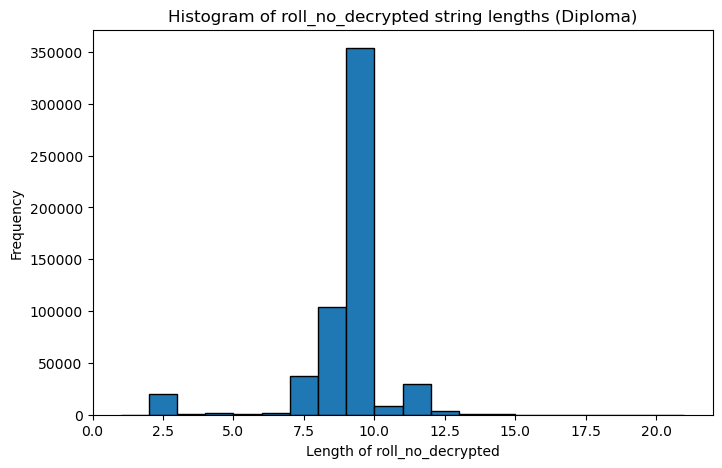

In [ ]:
import matplotlib.pyplot as plt
# built the histogram to check the string lenghth of roll no decrypted for diploma_df
# Calculate string lengths
lengths = iti_df["roll_no_decrypted"].astype(str).str.len()

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(lengths.min(), lengths.max() + 2), edgecolor='black')
plt.xlabel("Length of roll_no_decrypted")
plt.ylabel("Frequency")
plt.title("Histogram of roll_no_decrypted string lengths (Diploma)")
plt.show()

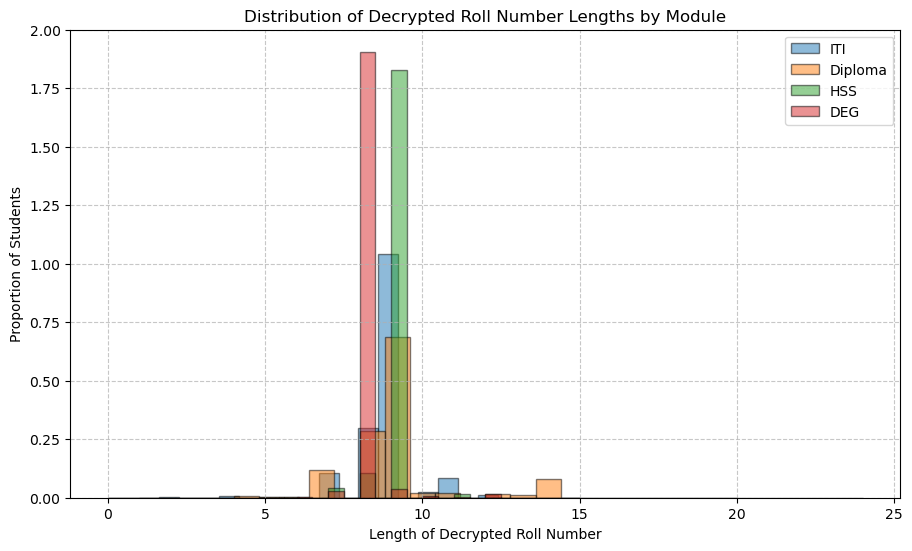

In [ ]:
# Compute decrypted roll number lengths for each module
lengths_data = {
    "ITI": iti_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "Diploma": diploma_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "HSS": hss_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "DEG": deg_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
}

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each module's length distribution as a histogram
for label, lengths in lengths_data.items():
    ax.hist(lengths, bins=30, alpha=0.5, label=label, edgecolor="black", density=True)

# Formatting
ax.set_title("Distribution of Decrypted Roll Number Lengths by Module")
ax.set_xlabel("Length of Decrypted Roll Number")
ax.set_ylabel("Proportion of Students")

# Set Y-axis ticks (e.g., 0%, 2%, ..., 10%)
yticks = np.arange(0, 0.12, 0.02)
# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{int(y * 100)}%" for y in yticks])

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Add margin to avoid clipping left side
plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)

plt.show()


In [23]:
from IPython.display import display, display_html

# Step 1: Reuse your DB row counts
db_path = datasets["sams"]["path"]   
conn = sqlite3.connect(db_path)

query = """
SELECT
    module,
    academic_year,
    COUNT(*) AS total_count
FROM students
GROUP BY module, academic_year
"""
db_totals = pd.read_sql_query(query, conn)
conn.close()

In [24]:
def compute_missing_by_year(df, key_vars, module_name):
    """
    Returns a dataframe showing missing value counts per academic_year for key_vars, joined with DB total count.
    """
    results = []

    for var in key_vars:
        # Count missing by academic_year
        missing = (
            df.groupby('academic_year')[var]
            .apply(lambda x: x.isna().sum() + x.isin(["", "NA", "na"]).sum())
            .reset_index(name=var)
        )
        results.append(missing)

    # Merge all missing count columns together on academic_year
    merged = results[0]
    for r in results[1:]:
        merged = merged.merge(r, on='academic_year', how='outer')

    # Add total counts from DB
    db_counts = db_totals[db_totals["module"] == module_name]
    final = db_counts.merge(merged, on='academic_year', how='left')
    # Avoid inserting duplicate 'module' column
    if 'module' in final.columns:
        final = final.drop(columns=['module'])

    final.insert(0, 'module', module_name)
    return final


In [25]:
key_vars = ["student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board"]

iti_missing = compute_missing_by_year(iti_df, key_vars, "ITI")
diploma_missing = compute_missing_by_year(diploma_df, key_vars, "Diploma")
hss_missing = compute_missing_by_year(hss_df, key_vars, "HSS")
deg_missing = compute_missing_by_year(deg_df, key_vars, "DEG")


In [26]:
display_html("<h3>ITI Variables Missing by Year</h3>", raw=True)
display(iti_missing)

display_html("<h3>Diploma Variables Missing by Year</h3>", raw=True)
display(diploma_missing)

display_html("<h3>HSS Variables Missing by Year</h3>", raw=True)
display(hss_missing)

display_html("<h3>DEG Variables Missing by Year</h3>", raw=True)
display(deg_missing)


ITI Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,ITI,2017,34654,0,0,0,20254,0,0
1,ITI,2018,75211,0,0,0,37861,0,0
2,ITI,2019,64148,0,0,0,18950,0,0
3,ITI,2020,67415,0,0,0,14209,0,0
4,ITI,2021,68000,0,0,0,13792,0,0
5,ITI,2022,74104,0,0,0,12745,0,0
6,ITI,2023,92085,0,0,0,13272,0,0
7,ITI,2024,83958,0,0,0,9121,0,0


Diploma Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,Diploma,2018,64218,0,0,0,34934,0,0
1,Diploma,2019,57824,0,0,0,19674,0,0
2,Diploma,2020,56600,0,0,0,16515,0,0
3,Diploma,2021,59278,0,0,0,13768,0,0
4,Diploma,2022,78196,0,0,0,15238,0,0
5,Diploma,2023,79700,0,0,0,11695,0,0
6,Diploma,2024,81789,0,0,0,10436,0,0


HSS Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,HSS,2018,439528,0,0,0,32033,0,0
1,HSS,2019,411118,0,0,0,20221,0,0
2,HSS,2020,431636,0,0,0,16104,0,0
3,HSS,2021,498180,0,0,0,15083,0,0
4,HSS,2022,574238,0,0,0,14906,0,0
5,HSS,2023,560769,0,0,2,8680,0,0
6,HSS,2024,537932,0,0,0,8700,0,0


DEG Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,DEG,2018,312823,0,0,0,986,0,0
1,DEG,2019,254342,0,0,0,1389,0,0
2,DEG,2020,242661,0,0,0,1522,0,0
3,DEG,2021,264152,0,0,0,1263,0,0
4,DEG,2022,379911,0,0,0,1136,0,0
5,DEG,2023,289849,0,0,0,30,0,0
6,DEG,2024,310753,0,0,0,44,0,0


In [ ]:
with pd.ExcelWriter("missing_key_field.xlsx", engine="openpyxl") as writer:
    # Write ITI first
    iti_missing.to_excel(writer, sheet_name="Missing by Year", startrow=1, index=False)
    worksheet = writer.sheets["Missing by Year"]
    worksheet.cell(row=1, column=1).value = "ITI Variables Missing by Year"

    # Write Diploma below ITI
    startrow = len(iti_missing) + 4
    diploma_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "Diploma Variables Missing by Year"

    # Write HSS below Diploma
    startrow += len(diploma_missing) + 3
    hss_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "HSS Variables Missing by Year"

    # Write DEG below HSS
    startrow += len(hss_missing) + 3
    deg_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "DEG Variables Missing by Year"


In [12]:
def encode_part(s: pd.Series, *, na_label="NA", missing_label="MISSING", lower=False) -> pd.Series:
    """
    Encode parts of a student key by handling missing/NA values consistently.
    """
    is_nan = s.isna()
    t = s.astype(str).str.strip()
    t = t.str.strip('"').str.strip("'")   # remove quotes if present

    out = t.copy()

    # Replace explicit NA and missing values
    out = out.mask(t.eq("NA"), na_label)
    out = out.mask(t.eq("") | is_nan, missing_label)

    # Normalize casing if requested
    if lower:
        out = out.where(out.isin([na_label, missing_label]), out.str.lower().str.strip())

    return out


In [13]:
def generate_student_key_df(df, module_name: str) -> pd.DataFrame:
    """
    Clean key columns in-place, then generate a student_key
    and print diagnostics about duplicates.
    """
    new_df = df.copy()

    # Columns used for the key
    key_vars = ["student_name", "passing_year", "dob",
                "roll_no_decrypted", "exam_board", "examination_type"]

    # Normalize these columns 
    for col in key_vars:
        new_df[col] = encode_part(new_df[col], lower=True)

    # Construct student key explicitly
    new_df["student_key"] = (
        new_df["student_name"] + "_" +
        new_df["passing_year"] + "_" +
        new_df["dob"] + "_" +
        new_df["roll_no_decrypted"] + "_" +
        new_df["exam_board"] + "_" +
        new_df["examination_type"]
    )

    # Diagnostics
    total_records = len(new_df)
    unique_aadhar = new_df["aadhar_no"].nunique()
    unique_keys = new_df["student_key"].nunique()

    # Problematic duplicates = same key linked to multiple Aadhaar numbers
    dup_check = (
        new_df.groupby("student_key")["aadhar_no"]
        .nunique(dropna=True)
        .reset_index(name="unique_aadhar_count")
    )
    problematic_keys = dup_check[dup_check["unique_aadhar_count"] > 1]["student_key"]

    # Count of problematic duplicate keys
    duplicate_keys_count = len(problematic_keys)

    # Count of rows affected by those problematic keys
    # duplicate_rows_count = new_df[new_df["student_key"].isin(problematic_keys)].shape[0]

    print(f"\n[{module_name}]")
    print("Total student records:", total_records)
    print("Unique Aadhaar numbers:", unique_aadhar)
    print("Unique student keys generated:", unique_keys)
    print("Duplicate student keys:", duplicate_keys_count)
    # print("Total rows having duplicate keys:", duplicate_rows_count)

    return new_df


In [14]:
# Generate student key datasets
iti_key_df = generate_student_key_df(iti_df, "ITI")
diploma_key_df = generate_student_key_df(diploma_df, "Diploma")
hss_key_df = generate_student_key_df(hss_df, "HSS")
deg_key_df = generate_student_key_df(deg_df, "DEG")


[ITI]
Total student records: 559575
Unique Aadhaar numbers: 518025
Unique student keys generated: 524797
Duplicate student keys: 1807

[Diploma]
Total student records: 477605
Unique Aadhaar numbers: 417756
Unique student keys generated: 445275
Duplicate student keys: 4320

[HSS]
Total student records: 3453401
Unique Aadhaar numbers: 2650770
Unique student keys generated: 2889836
Duplicate student keys: 113034

[DEG]
Total student records: 1909790
Unique Aadhaar numbers: 1494453
Unique student keys generated: 1532779
Duplicate student keys: 2805


In [ ]:
# create a table by year (firt column should be the year), 
# make for both iti diploma- total 4 column, 
# total addhar number, total unique id that can match with there one addhar 
# like exact 1 on 1 coreesponsind unique match, 
# total admittedd/enrolled for that year

# for hss and deg find, total unique applicant, total admitteed


# 11 column in total for each year
# calcaulte how many student keys is corresponding match to 1 eaxctly aadhar no for each year and aggreate to alst table
#let's do for the ITI first
# so my columns should be year, total enrolled students, total unique addhar, 
# total unique id, total number with exact 1 on 1 match with aadhar no and student key and last total admitted students

In [56]:
hss_enroll.head()

,academic_year,barcode,aadhar_no,dob,year_of_passing,roll_no,examination_type,examination_board_of_the_highest_qualification,admission_status
0,2018,18J0054157,,07-Jul-2002,2018,OQpGykhOnzUDRJkE5xDqhA==,Annual,"BSE, Odisha",No
1,2018,18J0054211,,05-Dec-2002,2018,GGqv3Kdo8HZyK68MvPXQXg==,Annual,"BSE, Odisha",No
2,2018,18J0054354,,25-Aug-2003,2018,cHtLfCL89qhpsPRWMhcMCg==,Annual,"BSE, Odisha",No
3,2018,18J0054431,,20-Apr-2003,2018,0Cx1ngpH/vvmun5PtcC9yA==,Annual,"BSE, Odisha",No
4,2018,18J0054684,,20-Mar-2001,2018,d7usWOp/eZSqwAjwzjD4UA==,Annual,"BSE, Odisha",No


In [29]:
def create_yearly_summary(df):
    """Generate yearly summary for ITI or Diploma datasets."""
    def _metrics(g):
        mapping = g[['aadhar_no', 'student_key']].drop_duplicates()
        unique_aadhar = mapping['aadhar_no'].value_counts() == 1
        unique_key = mapping['student_key'].value_counts() == 1

        one_to_one = mapping[
            mapping['aadhar_no'].isin(unique_aadhar[unique_aadhar].index) &
            mapping['student_key'].isin(unique_key[unique_key].index)
        ]
        # MODIFIED: Renamed keys to remove 'total_' prefix.
        # 'total_aadhar' -> 'aadhar', 'total_1by1_match' -> '1by1_match'
        return pd.Series({
            'aadhar': g['aadhar_no'].nunique(),
            '1by1_match': len(one_to_one),
            'admitted': g['admission_status'].astype(str).str.lower().eq('yes').sum(),
        })

    return (
        df.groupby('academic_year', group_keys=False)
        .apply(_metrics)
        .reset_index()
    )


def create_admissions_summary(df, prefix):
    """
    Summarize yearly applicants and admissions by status for HSS or Degree.
    """
    return (
        df.groupby('academic_year')
        .agg(
            # MODIFIED: Renamed all keys to remove 'total_' and 'unique_' prefixes for simplicity.
            # e.g., f'{prefix}_total_admitted' is now f'{prefix}_admitted'
            **{
                f'{prefix}_applicant': ('aadhar_no', 'nunique'),
                
                f'{prefix}_admitted': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'admitted').sum()
                ),
                
                f'{prefix}_tc_taken': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'tc taken').sum()
                ),

                f'{prefix}_not_selected': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'not selected').sum()
                ),

                f'{prefix}_selected_but_not_admitted': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'selected but not admitted').sum()
                ),
            }
        )
        .reset_index()
    )


# --- Code for generating and merging summaries ---
# (No changes needed in this section)

# Generate summaries 
iti_summary = create_yearly_summary(iti_key_df)
diploma_summary = create_yearly_summary(diploma_key_df)
hss_summary = create_admissions_summary(hss_key_df, prefix='hss')
deg_summary = create_admissions_summary(deg_key_df, prefix='deg')


# Merge all yearly summaries 
final_summary = (
    iti_summary.merge(
        diploma_summary, on='academic_year', how='outer', suffixes=('_iti', '_diploma')
    )
    .merge(hss_summary, on='academic_year', how='outer')
    .merge(deg_summary, on='academic_year', how='outer')
)


# MODIFIED: The rename logic is updated to handle the new, simpler column names.
# The merge operation creates columns like 'aadhar_iti'. We rename them to 'iti_aadhar'.
# Columns from HSS and Degree (e.g., 'hss_admitted') are already named correctly and don't need renaming.
final_summary.rename(
    columns={
        'academic_year': 'year',
        # ITI columns: from `metric_iti` to `iti_metric`
        'aadhar_iti': 'iti_aadhar',
        '1by1_match_iti': 'iti_1by1_match',
        'admitted_iti': 'iti_admitted',
        'tc_taken_iti': 'iti_tc_taken',
        # Diploma columns: from `metric_diploma` to `diploma_metric`
        'aadhar_diploma': 'diploma_aadhar',
        '1by1_match_diploma': 'diploma_1by1_match',
        'admitted_diploma': 'diploma_admitted',
        'tc_taken_diploma': 'diploma_tc_taken',
    },
    inplace=True,
)


# MODIFIED: Reordered columns to use the new, simplified names.
final_summary = final_summary[
    [
        'year',
        # ITI Columns
        'iti_aadhar', 'iti_1by1_match',
        # Diploma Columns
        'diploma_aadhar', 'diploma_1by1_match', 
        # HSS Columns 
        'hss_applicant', 
        # 'hss_admitted', 
        # 'hss_tc_taken', 
        # 'hss_not_selected', 
        # 'hss_selected_but_not_admitted',
        # Degree Columns 
        'deg_applicant', 
        # 'deg_admitted',
        # 'deg_tc_taken',
        # 'deg_not_selected',
        # 'deg_selected_but_not_admitted',
    ]
]

# Display the final summary DataFrame
final_summary

C:\Users\Admin\AppData\Local\Temp\ipykernel_23684\876853288.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_metrics)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23684\876853288.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_metrics)


,year,iti_aadhar,iti_1by1_match,diploma_aadhar,diploma_1by1_match,hss_applicant,deg_applicant
0,2017,27337,13934,NaN,NaN,NaN,NaN
1,2018,70613,40222,52530.0,29236.0,367580.0,204304.0
2,2019,64148,50162,44080.0,33924.0,355307.0,200209.0
3,2020,67412,58395,56533.0,46267.0,345900.0,191842.0
4,2021,68000,59523,59278.0,51453.0,375367.0,250724.0
5,2022,74104,66395,78196.0,69400.0,420678.0,256801.0
6,2023,92085,84467,79700.0,73736.0,419134.0,236544.0
7,2024,83958,79603,81789.0,76710.0,473096.0,262392.0


In [19]:
#export final summary to excel
final_summary.to_excel("sams_unique_id_aggregates_oct_28th_master_doc.xlsx", index=False)

In [54]:
def calculate_yearly_summary(year_group):
    """
    Compute key yearly statistics for ITI or Diploma data.
    Includes counts of Aadhaar–student_key relationships and admissions.
    """
    # Count total admitted students
    total_admitted = year_group['admission_status'].astype(str).str.lower().eq('yes').sum()

    # Drop duplicate (aadhar, student_key) pairs for accurate relationship mapping
    mapping_df = year_group[['aadhar_no', 'student_key']].drop_duplicates()

    # Frequency counts of Aadhaar numbers and student keys
    aadhar_counts = mapping_df['aadhar_no'].value_counts()
    key_counts = mapping_df['student_key'].value_counts()

    # Identify many-to-one and one-to-many relationships
    aadhars_with_multiple_keys = (aadhar_counts > 1).sum()
    keys_with_multiple_aadhars = (key_counts > 1).sum()

    # Identify truly unique Aadhaar–key pairs (1:1 matches)
    unique_aadhars = aadhar_counts[aadhar_counts == 1].index
    unique_keys = key_counts[key_counts == 1].index
    exact_1on1_matches = mapping_df[
        mapping_df['aadhar_no'].isin(unique_aadhars) &
        mapping_df['student_key'].isin(unique_keys)
    ]

    # Return computed yearly metrics
    return pd.Series({
        "total_rows": len(year_group),
        "unique_aadhar": year_group['aadhar_no'].nunique(),
        "unique_student_keys": year_group['student_key'].nunique(),
        "exact_1on1_matches": len(exact_1on1_matches),
        "aadhars_with_multiple_keys": aadhars_with_multiple_keys,
        "keys_with_multiple_aadhars": keys_with_multiple_aadhars,
        "total_admitted": total_admitted,
    })


# Compute yearly summary for ITI data
iti_summary = iti_key_df.groupby('academic_year').apply(calculate_yearly_summary).reset_index()
iti_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_16976\3216008542.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  iti_summary = iti_key_df.groupby('academic_year').apply(calculate_yearly_summary).reset_index()


,academic_year,total_rows,unique_aadhar,unique_student_keys,exact_1on1_matches,aadhars_with_multiple_keys,keys_with_multiple_aadhars,total_admitted
0,2017,34654,27337,29989,26065,358,819,13801
1,2018,75211,70613,71194,69617,714,149,50213
2,2019,64148,64148,64133,64119,0,14,47585
3,2020,67415,67412,67413,67407,1,2,43728
4,2021,68000,68000,67987,67974,0,13,45223
5,2022,74104,74104,74090,74077,0,13,39526
6,2023,92085,92085,92077,92069,0,8,62756
7,2024,83958,83958,83958,83958,0,0,60538


In [ ]:
hss_enrollments.columns

Index(['barcode', 'aadhar_no', 'academic_year', 'module', 'gender', 'dob',
       'social_category', 'orphan', 'es', 'ph', 'state', 'district', 'address',
       'block', 'pin_code', 'annual_income', 'roll_no',
       'highest_qualification', 'board_exam_name_for_highest_qualification',
       'examination_board_of_the_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_option_details', 'hss_compartments'],
      dtype='object')

In [36]:
# Final processed datasets
print("Diploma dataset shape:", diploma_key_df.shape)
print("ITI dataset shape:", iti_key_df.shape)

# Preview duplicates
# diploma_key_df[diploma_key_df["student_key"].isin(
#     diploma_key_df["student_key"].value_counts()[lambda x: x > 1].index
# )]

iti_key_df[iti_key_df["student_key"].isin(
    iti_key_df["student_key"].value_counts()[lambda x: x > 1].index
)].head()

Diploma dataset shape: (558879, 13)
ITI dataset shape: (559575, 13)


,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,student_key
0,7404718,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,AKASH GARNAYAK,01-Jan-2002,10TH,"""2017""","""PoLOLFcCUYZ/iR42DWBy2A==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",105AE0003,akash garnayak_2017_01-jan-2002_105ae0003_boar...
2,7404720,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,ANIL MOHARANA,07-Oct-2001,10TH,"""2017""","""LjH/WJQkl9UJzVJCu+CaSQ==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",170AF0002,anil moharana_2017_07-oct-2001_170af0002_board...
4,7404722,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,BABULI MAJHI,20-Apr-1999,12 TH,"""2014""","""BpFNV6ZmrmdtbEcHJS6eGg==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",NA,babuli majhi_2014_20-apr-1999_NA_board of seco...
5,7404723,2017,17T0368940,kE8pjcVYaloR8h7MHt9Lvf69OKmOVQlAXCsPWNMy72o=,BHAKTA TUDU,21-Feb-1999,10TH,"""2015""","""5IvZQeYaKHJj3t5Mz1hGdQ==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",NA,bhakta tudu_2015_21-feb-1999_NA_board of secon...
7,7404725,2017,17T03659610,AM1BwT3d2R+NQ2nuBdCHt4Qhw83J+GG5svrRrRWvjrE=,BISWAJIT BEHERA,14-Mar-2002,,"""2017""","""ygiPoVgEWXgegbZaYL66Aw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",105AE0018,biswajit behera_2017_14-mar-2002_105ae0018_boa...


In [37]:
def enrollment_key_summary(df, module_name: str = None):
    """
    Generate per-year aggregates of enrollment, Aadhaar, and student keys.
    Includes totals and differences to flag duplicates/mismatches.
    """
    grp = df.groupby("academic_year")

    summary = pd.concat([
        grp["aadhar_no"].count().rename("total_enrolled"),
        # grp["aadhar_no"].nunique().rename("unique_aadhar"),
        grp["student_key"].nunique().rename("unique_student_keys"),
    ], axis=1).reset_index()

    # Differences
    # summary["diff_enroll_vs_aadhar"] = summary["total_enrolled"] - summary["unique_aadhar"]
    summary["diff_enroll_vs_keys"] = summary["total_enrolled"] - summary["unique_student_keys"]
    # summary["diff_aadhar_vs_keys"] = summary["unique_aadhar"] - summary["unique_student_keys"]

    # Add totals row
    totals = {
        "academic_year": "All Years",
        "total_enrolled": summary["total_enrolled"].sum(),
        # "unique_aadhar": summary["unique_aadhar"].sum(),
        "unique_student_keys": summary["unique_student_keys"].sum(),
        # "diff_enroll_vs_aadhar": summary["diff_enroll_vs_aadhar"].sum(),
        "diff_enroll_vs_keys": summary["diff_enroll_vs_keys"].sum(),
        # "diff_aadhar_vs_keys": summary["diff_aadhar_vs_keys"].sum(),
    }
    summary = pd.concat([summary, pd.DataFrame([totals])], ignore_index=True)

    if module_name:
        print(f"\n[{module_name}] Enrollment & Stats")
    return summary

In [38]:
iti_enrollment_summary = enrollment_key_summary(iti_key_df, "ITI")
iti_enrollment_summary


[ITI] Enrollment & Stats


,academic_year,total_enrolled,unique_student_keys,diff_enroll_vs_keys
0,2017,34654,29989,4665
1,2018,75211,71194,4017
2,2019,64148,64133,15
3,2020,67415,67413,2
4,2021,68000,67987,13
5,2022,74104,74090,14
6,2023,92085,92077,8
7,2024,83958,83958,0
8,All Years,559575,550841,8734


In [39]:
hss_enrollment_summary = enrollment_key_summary(hss_key_df, "HSS")
hss_enrollment_summary


[HSS] Enrollment & Stats


,academic_year,total_enrolled,unique_student_keys,diff_enroll_vs_keys
0,2018,387069,410424,-23355
1,2019,375768,387103,-11335
2,2020,374368,394490,-20122
3,2021,403448,446480,-43032
4,2022,491504,482548,8956
5,2023,479176,480728,-1552
6,2024,520066,487117,32949
7,All Years,3031399,3088890,-57491


In [ ]:
hss_key_df

In [53]:
# Count total rows per key
key_counts = hss_key_df["student_key"].value_counts()

# Count unique Aadhaar per key
aadhar_counts = hss_key_df.groupby("student_key")["aadhar_no"].nunique(dropna=True)

# Keep only keys that repeat and link to >1 Aadhaar
problematic_keys = key_counts[(key_counts > 1) & (aadhar_counts > 1)]

print("Total problematic duplicate keys:", len(problematic_keys))
problematic_keys.head()

Total problematic duplicate keys: 5011


student_key
nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2018.0_2002-12-20_6120996_cbse, new delhi_annual         8
aiagpi2hyf/l5d6dirzrjae9jlpc04jo9bgr357lx2g=_2020.0_2002-01-17_146cd0049_bse, odisha_supplementary    7
2imr0jd1w89i1avouwr5s7k7ogd5mpgfxd/ngpxq0lu=_2020.0_2004-02-13_042ef0079_bse, odisha_annual           6
3ejnstxwrqf7xo2l0wsxbmmvhge1odfw2htrupf/hnm=_2021.0_2005-08-07_206eg0058_bse, odisha_annual           6
zwikl1d9wcz2sudl41ltzinq+asldttg8uy9wam8+ua=_2021.0_2005-04-15_034fd0265_bse, odisha_annual           6
Name: count, dtype: int64